In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import image as nimg
from nilearn import plotting as nplot
import bids
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator
import os
from pathlib import Path
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
from nilearn.plotting import plot_contrast_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
# creating mean img for plotting purposes 
from nilearn.image import mean_img
from nilearn.image import load_img
from nibabel import load
from nibabel.gifti import GiftiDataArray, GiftiImage
from nilearn.glm.first_level import run_glm as run_glm
from nilearn.glm import compute_contrast
import nilearn
fsaverage = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage')

# Making results folder -- change to what this should actually be 
path = '/Volumes/Seagate Desktop Drive/NARSAD/'
os.chdir(path)


## ECR diffs - patients vs controls: 

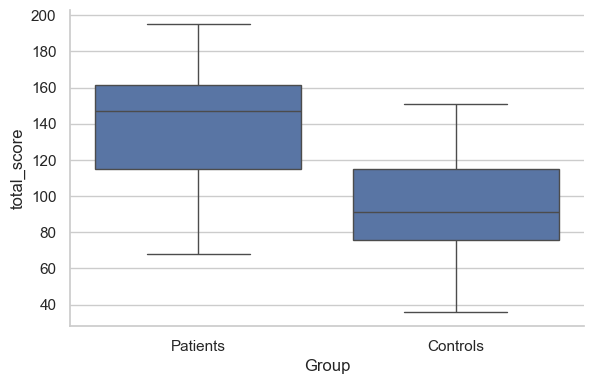

Mean and SEM for total_score:
Controls - Mean: 93.679, SEM: 3.777
Patients - Mean: 139.353, SEM: 4.318
T-test results for total_score:
T-statistic: 7.961, P-value: 0.000



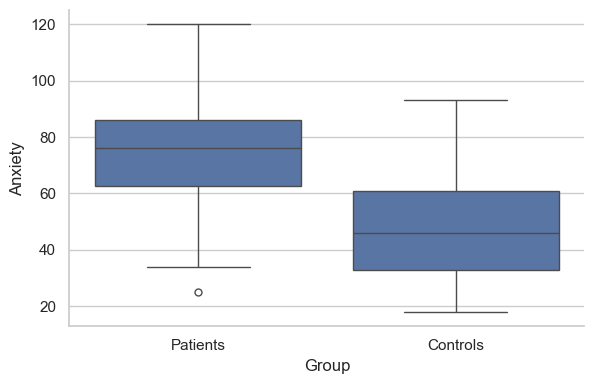

Mean and SEM for Anxiety:
Controls - Mean: 48.623, SEM: 2.588
Patients - Mean: 74.569, SEM: 2.704
T-test results for Anxiety:
T-statistic: 6.933, P-value: 0.000



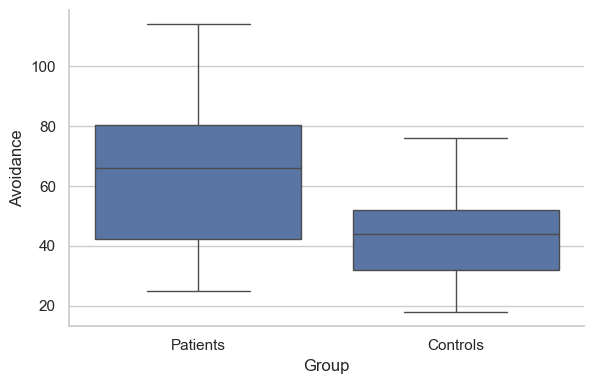

Mean and SEM for Avoidance:
Controls - Mean: 45.057, SEM: 2.256
Patients - Mean: 64.784, SEM: 3.235
T-test results for Avoidance:
T-statistic: 5.002, P-value: 0.000



In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Load the Excel sheet
ecr_data = pd.read_excel('ECR.xlsx')

# Create a new column for the group based on subID
ecr_data['Group'] = ecr_data['subID'].apply(lambda x: 'Patients' if x.startswith('N1') else 'Controls')

# Set up the plotting environment
sns.set(style="whitegrid")

# Create a catplot for each variable
for variable in ['total_score', 'Anxiety', 'Avoidance']:
    g = sns.catplot(x='Group', y=variable, data=ecr_data, kind='box', height=4, aspect=1.5)
    g.set_axis_labels("Group", variable)
    g.set_titles(f"{variable} by Group")
    plt.show()

    # Calculate means and SEM
    mean_values = ecr_data.groupby('Group')[variable].mean()
    sem_values = ecr_data.groupby('Group')[variable].sem()

    # Print means and SEM
    print(f"Mean and SEM for {variable}:")
    for group in mean_values.index:
        print(f"{group} - Mean: {mean_values[group]:.3f}, SEM: {sem_values[group]:.3f}")

    # Perform t-test
    patients = ecr_data[ecr_data['Group'] == 'Patients'][variable]
    controls = ecr_data[ecr_data['Group'] == 'Controls'][variable]
    
    t_stat, p_value = stats.ttest_ind(patients, controls, equal_var=False)  # Welch's t-test

    print(f"T-test results for {variable}:")
    print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}\n")


## Phase 1: Acquisition

#### Data loading

In [21]:
import os

path = '/Volumes/Seagate Desktop Drive/NARSAD/SCR'
os.chdir(path)

import pandas as pd
import numpy as np

# Parameters
trialnumber = range(1, 25)  # Can adjust to first half of trials: range(1, 13)
excludeparticipants = 1  # Set to 0 to include all participants
rejtrials_threshold = 24  # Adjust the threshold as needed

# Load the table
peakstatstable = pd.read_csv('peak_stats_table-phase1.csv')

# Extract unique participant IDs and trial types
participants = peakstatstable['sid'].unique()
trial_types = peakstatstable['stTy'].unique()

# Group data by participant
participant_groups = peakstatstable.groupby('sid')
dat = []

for participant_id in participants:
    data = participant_groups.get_group(participant_id)
    subject_data = {'subID': participant_id}

    # Process data if there are 24 trials
    if len(data) == 24:
        phase1_data = data[data['stNum'].isin(trialnumber)]

        # Rejected trials (based on "Publication recommendations for electrodermal measurements")
        rejTrials = phase1_data[phase1_data['phaBase2Peak'] < 0].index
        phase1_data.loc[rejTrials, 'phaBase2Peak'] = 0  # Mark non-response trials as 0

        subject_data['rejTrials1'] = len(rejTrials)

        # Separate data by stim type
        stim_groups = phase1_data.groupby('stTy')

        try:
            # Calculate mean, SE, and count for CSS, CSR, and CS-
            css_data = stim_groups.get_group('CS+S')
            subject_data['meanCSS1'] = css_data['phaBase2Peak'].mean()
            subject_data['seCSS1'] = css_data['phaBase2Peak'].std() / np.sqrt(len(css_data))
            subject_data['nCSS1'] = len(css_data)

            csr_data = stim_groups.get_group('CS+R')
            subject_data['meanCSR1'] = csr_data['phaBase2Peak'].mean()
            subject_data['seCSR1'] = csr_data['phaBase2Peak'].std() / np.sqrt(len(css_data))
            subject_data['nCSR1'] = len(csr_data)

            csminus_data = stim_groups.get_group('CS-')
            subject_data['meanCSminus1'] = csminus_data['phaBase2Peak'].mean()
            subject_data['seCSminus1'] = csminus_data['phaBase2Peak'].std() / np.sqrt(len(css_data))
            subject_data['nCSminus1'] = len(csminus_data)

        except KeyError:
            print(f"Missing stim type data for participant {participant_id}")
        
    dat.append(subject_data)

# Convert to a DataFrame if you need a structured output
dat_df = pd.DataFrame(dat)
print(dat_df)


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
    subID  rejTrials1  meanCSS1    seCSS1  nCSS1  meanCSR1    seCSR1  nCSR1  \
0    N101           4  0.034000  0.020075      8  0.010125  0.007352      8   
1    N102           0  0.003625  0.001558      8  0.000875  0.000295      8   
2    N103           1  0.117500  0.020816      8  0.132125  0.025778      8   
3    N104           5  0.001625  0.000944      8  0.001125  0.000581      8   
4    N105           2  0.004625  0.001945      8  0.001625  0.000981      8   
..    ...         ...       ...       ...    ...       ...       ...    ...   
99   N255           6  0.001000  0.000681      8  0.001250  0.000750      8   
100  N257           4  0.031875  0.010315      8  0.041125  0.021445      8   
101  N258           0  0.034000  0.006980      8  0.029000  0.007533      8   
102  N259           2  0.015000  0.004706      8  0.0208

#### Acquisition SCR results: CSR and CSS kept separate 

basically only see an effect of patient group (not even stim type) when testing for main effect of ECR, ECR-anxiety, or ECR-avoidance; ECR doesn't seem to play a significant role in direct fear acquisition

In [29]:
# intercept included cs- data, control data, placebo data see specific effect of drug, css, csr, etc. 
path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('ECR.xlsx')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['ECR_total'] = merged_data['total_score']  # Gender as categorical
merged_data['ECR_anxiety'] = merged_data['Anxiety']  # Drug as categorical
merged_data['ECR_avoidance'] = merged_data['Avoidance']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'ECR_total','ECR_avoidance','ECR_anxiety'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 1, 
    'meanCSS1': 2, 
    'meanCSminus1': 3
})


# Model formula including main effect of stim_type
model_formula = 'response ~ patient_group + stim_type + ECR_avoidance'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2.710
Date:                Fri, 01 Nov 2024   Prob (F-statistic):             0.0452
Time:                        13:15:57   Log-Likelihood:                 302.72
No. Observations:                 312   AIC:                            -597.4
Df Residuals:                     308   BIC:                            -582.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0869      0.019      4.587

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60537/2693751170.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


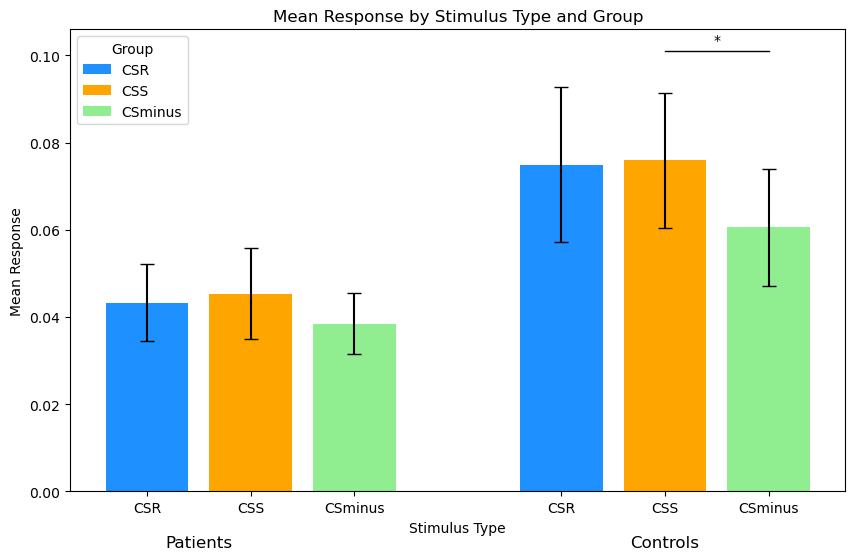

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 'CSR', 
    'meanCSS1': 'CSS', 
    'meanCSminus1': 'CSminus'
})

# Calculate means and errors
group_means = long_data.groupby(['patient_group', 'stim_type'])['response'].mean().reset_index()
group_sems = long_data.groupby(['patient_group', 'stim_type'])['response'].sem().reset_index()

# Set up custom x positions for the bars (grouped with a gap between patients and controls)
x_positions = {
    ('patient', 'CSR'): 0, ('patient', 'CSS'): 1, ('patient', 'CSminus'): 2,
    ('control', 'CSR'): 4, ('control', 'CSS'): 5, ('control', 'CSminus'): 6
}

# Map x positions to data
group_means['x'] = group_means.apply(lambda row: x_positions[(row['patient_group'], row['stim_type'])], axis=1)
group_sems['x'] = group_means['x']

# Define colors for each stimulus type
stimulus_colors = {
    'CSR': 'dodgerblue',
    'CSS': 'orange',
    'CSminus': 'lightgreen'
}

# Plot bar chart
plt.figure(figsize=(10, 6))

for group in ['patient', 'control']:
    for stim in ['CSR', 'CSS', 'CSminus']:
        group_data = group_means[(group_means['patient_group'] == group) & (group_means['stim_type'] == stim)]
        group_errors = group_sems[(group_sems['patient_group'] == group) & (group_sems['stim_type'] == stim)]
        plt.bar(group_data['x'], group_data['response'], 
                color=stimulus_colors[stim], 
                label=stim if group == 'patient' else "",  # Label only for patients
                yerr=group_errors['response'], capsize=5)

# Add significance markers
def add_significance_markers(ax, comparisons, y_offset=0.02, bar_height=0.02):
    for (group1, stim1), (group2, stim2) in comparisons:
        if group1 == group2:
            # Paired t-test within the same group
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_rel(data1['response'], data2['response'])
        else:
            # Independent t-test between groups
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group2) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_ind(data1['response'], data2['response'], equal_var=False)
        
        if result.pvalue < 0.05:  # Customize significance level if needed
            x1 = x_positions[(group1, stim1)]
            x2 = x_positions[(group2, stim2)]
            max_y = group_means['response'].max() + 0.025  # Adjust this if needed
            ax.plot([x1, x2], [max_y, max_y], 'k-', lw=1)
            ax.text((x1 + x2) / 2, max_y + 0.001, '*', ha='center', va='bottom')

# Define comparisons
comparisons = [
    (('patient', 'CSR'), ('patient', 'CSS')),   # Patient CSR vs CSS
    (('patient', 'CSR'), ('patient', 'CSminus')),  # Patient CSR vs CSminus
    (('patient', 'CSS'), ('patient', 'CSminus')),  # Patient CSS vs CSminus
    (('control', 'CSR'), ('control', 'CSS')),   # Control CSR vs CSS
    (('control', 'CSR'), ('control', 'CSminus')),  # Control CSR vs CSminus
    (('control', 'CSS'), ('control', 'CSminus')),  # Control CSS vs CSminus
    (('patient', 'CSR'), ('control', 'CSR')),    # Between-group CSR
    (('patient', 'CSS'), ('control', 'CSS')),    # Between-group CSS
    (('patient', 'CSminus'), ('control', 'CSminus')) # Between-group CSminus
]

add_significance_markers(plt.gca(), comparisons)
# Add x-axis labels to indicate groups
plt.text(0.5, -0.01, 'Patients', ha='center', va='top', fontsize=12)
plt.text(5, -0.01, 'Controls', ha='center', va='top', fontsize=12)

# Labeling and finalizing plot
plt.xticks([0, 1, 2, 4, 5, 6], ['CSR', 'CSS', 'CSminus', 'CSR', 'CSS', 'CSminus'])
plt.xlabel('Stimulus Type')
plt.ylabel('Mean Response')
plt.title('Mean Response by Stimulus Type and Group')
plt.legend(title='Group')
plt.show()


#### Acquisition SCR results: CS+ combined from CSR/CSS

basically only see an effect of patient group (not even stim type) when testing for main effect of ECR, ECR-anxiety, or ECR-avoidance; ECR doesn't seem to play a significant role in direct fear acquisition

In [33]:
# averaging CSR and CSS into CS+ 

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('ECR.xlsx')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['ECR_total'] = merged_data['total_score']  # Gender as categorical
merged_data['ECR_anxiety'] = merged_data['Anxiety']  # Drug as categorical
merged_data['ECR_avoidance'] = merged_data['Avoidance']  # Drug as categorical

# Calculate the mean of CSR and CSS for each subject and create a new column for CS+
merged_data['CS_plus'] = merged_data[['meanCSR1', 'meanCSS1']].mean(axis=1)

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'ECR_total','ECR_avoidance','ECR_anxiety'], 
                    value_vars=['CS_plus', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'CS_plus': 1, 
    'meanCSminus1': 2
})

# Specify the model without intercept
model_formula = 'response ~ patient_group + stim_type + ECR_avoidance'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.934
Date:                Fri, 01 Nov 2024   Prob (F-statistic):              0.125
Time:                        13:19:41   Log-Likelihood:                 213.28
No. Observations:                 208   AIC:                            -418.6
Df Residuals:                     204   BIC:                            -405.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0908      0.024      3.720

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60537/2265053227.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


## Phase2 / 3 -- fmri + scr 

### Creating individual ROI masks: 
For each ROI, I used the functional association map from Neurosynth (links below) and then further anatomically constrained using the Harvard-Oxford maximum probabilistic map threshold25% 2mm

Neurosynth links: 
amygdala: https://www.neurosynth.org/analyses/terms/amygdala/
vmpfc: https://www.neurosynth.org/analyses/terms/vmpfc/
insula: https://www.neurosynth.org/analyses/terms/insula
ACC: https://www.neurosynth.org/analyses/terms/acc/
hippocampus: https://www.neurosynth.org/analyses/terms/hippocampus/
superior temporal sulcus: https://www.neurosynth.org/analyses/terms/sts/
temporoparietal junction: https://www.neurosynth.org/analyses/terms/tpj/
 
vmpfc anatomical constrained: 
Frontal Medial Cortex or Subcallosal Cortex -- cite: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7010285/




other vmpfc methods :
The vmPFC was defined as a 10 mm spherical ROI centered on the MNI coordinates xyz = 4, 32, −5 on the basis of prior researches (Phelps et al., 2004; Milad et al., 2007) -- cite: https://academic.oup.com/scan/article/11/6/991/2224359#126899120

or: 
vmPFC defined as 5mm sphere around MNI coordinates derived from this meta-analysis: https://pubmed.ncbi.nlm.nih.gov/26122585/
(like how this paper did it: https://www.nature.com/articles/s41386-021-01003-8#Sec2)



BIDS Layout: ...sktop Drive/NARSAD/derivatives | Subjects: 102 | Sessions: 102 | Runs: 10


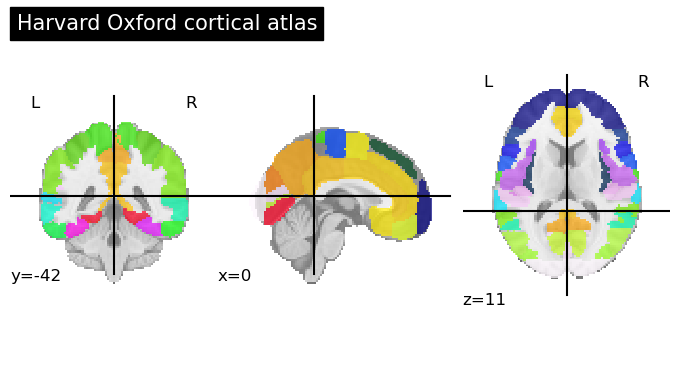

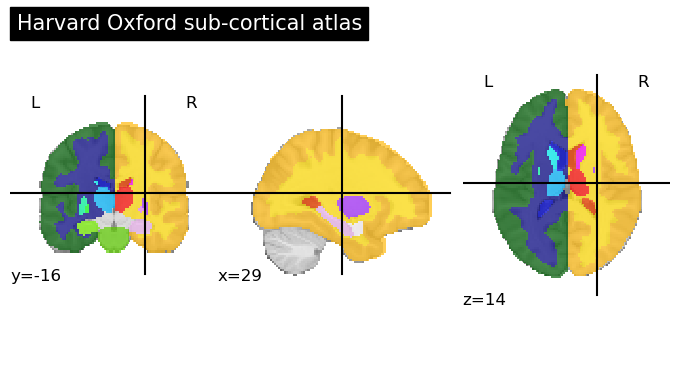

In [11]:
import numpy as np
from nilearn import datasets
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn import plotting, masking
from nilearn.masking import _unmask_3d
from nilearn.maskers import nifti_spheres_masker
import nibabel as nib
from nibabel import Nifti1Image
from nilearn.image import resample_to_img 

dataset_ho_cort = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm", symmetric_split=False) #changing from bilateral to combined left/right
atlas_ho_cort_filename = dataset_ho_cort.filename
plotting.plot_roi(atlas_ho_cort_filename, title="Harvard Oxford cortical atlas")

dataset_ho_sub = datasets.fetch_atlas_harvard_oxford("sub-maxprob-thr25-2mm", symmetric_split=False)
atlas_ho_sub_filename = dataset_ho_sub.filename
plotting.plot_roi(atlas_ho_sub_filename, title="Harvard Oxford sub-cortical atlas")

layout = bids.BIDSLayout('/Volumes/Seagate Desktop Drive/NARSAD/derivatives', validate=False,
                  config=['bids','derivatives'])
print(layout)

In [4]:
#making space defining image
sub = 'N234'
fmri_imgs = layout.get(subject=sub,
                        datatype='func',
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
space_defining_image = masking.compute_brain_mask(fmri_imgs[0])

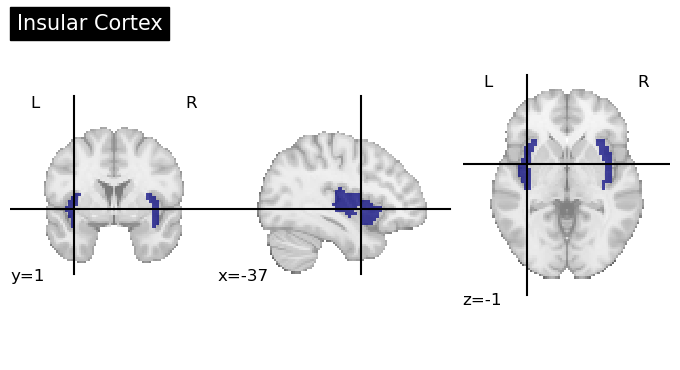

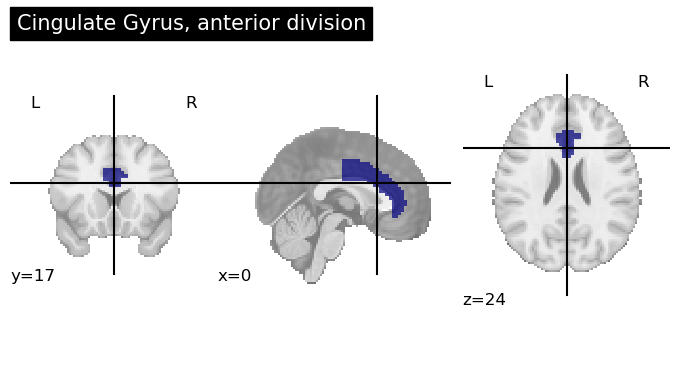

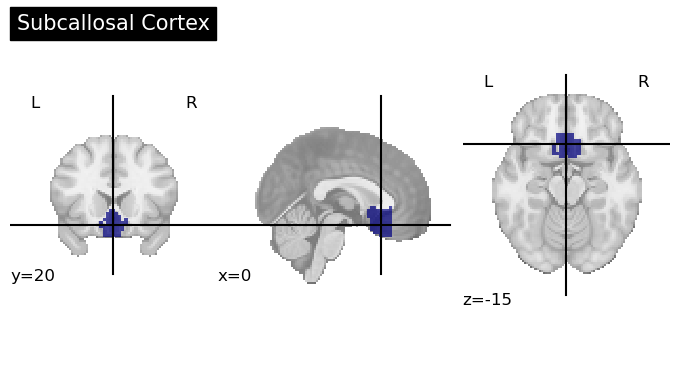

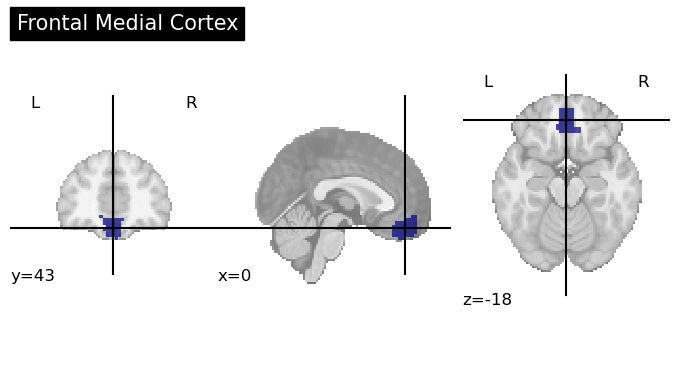

In [12]:
def create_and_plot_roi(label_of_interest, dataset, atlas_resampled):
    index_of_interest = dataset['labels'].index(label_of_interest)
    nii_data = atlas_resampled.get_fdata()
    roi_data = np.where(nii_data == index_of_interest, nii_data, 0)
    binarized_data = (roi_data > 0).astype(bool)
    
    roi_atlas = Nifti1Image(binarized_data, atlas_resampled.affine, header=atlas_resampled.header)
    plotting.plot_roi(roi_atlas, title=label_of_interest)
    
    return roi_atlas

#resample atlas map to data shape
atlas_sub_resampled = resample_to_img(source_img=dataset_ho_sub['maps'], target_img=space_defining_image, interpolation='nearest')
atlas_cort_resampled = resample_to_img(source_img=dataset_ho_cort['maps'], target_img=space_defining_image, interpolation='nearest')

# amygdala_atlas = create_and_plot_roi('Amygdala', dataset_ho_sub, atlas_sub_resampled)
insula_atlas = create_and_plot_roi('Insular Cortex', dataset_ho_cort, atlas_cort_resampled)
acc_atlas = create_and_plot_roi('Cingulate Gyrus, anterior division', dataset_ho_cort, atlas_cort_resampled)
# hippocampus_atlas = create_and_plot_roi('Hippocampus', dataset_ho_sub, atlas_sub_resampled)
vmpfc1_atlas = create_and_plot_roi('Subcallosal Cortex', dataset_ho_cort, atlas_cort_resampled)
vmpfc2_atlas = create_and_plot_roi('Frontal Medial Cortex', dataset_ho_cort, atlas_cort_resampled)

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/image/image.py:1106: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/image/image.py:1106: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/image/image.py:1106: UserWarning: Data array

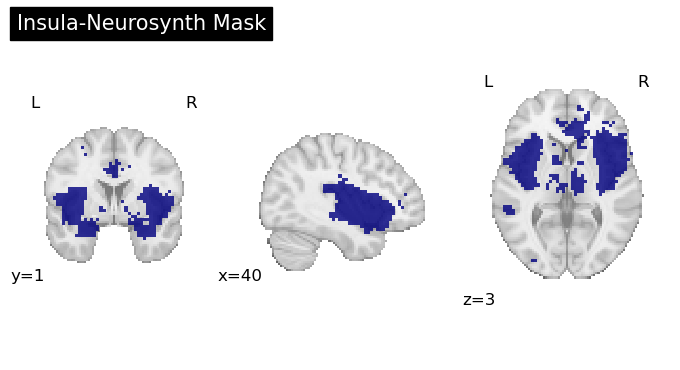

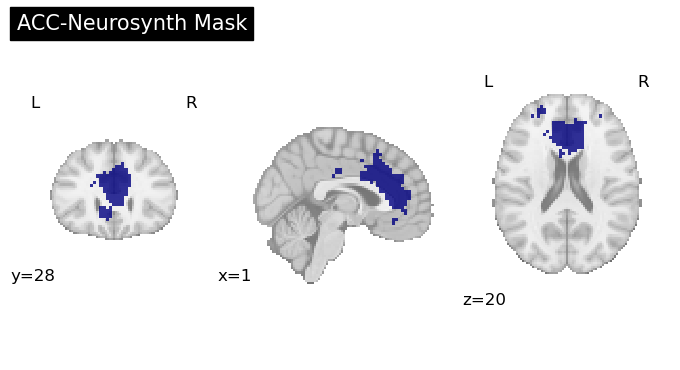

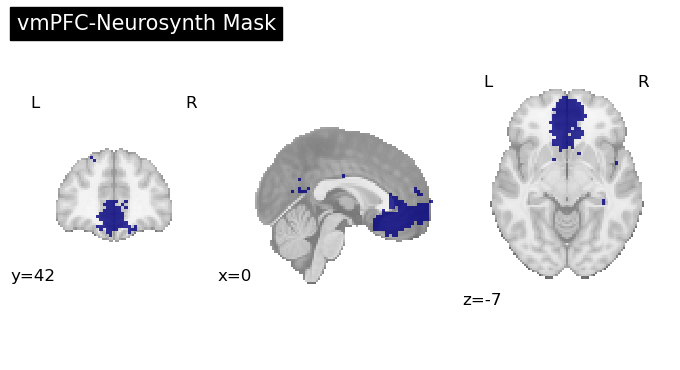

In [13]:
# load in/plot neurosynth masks: 
# #import Neurosynth masks:
from nilearn.image import binarize_img

# amygdala_func = load_img('/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/neurosynth-raw/amygdala.nii.gz')
# amygdala_func = binarize_img(resample_to_img(source_img=amygdala_func, target_img=space_defining_image, interpolation='nearest'))
# plotting.plot_roi(amygdala_func, draw_cross=False, alpha=0.8, title='Amygdala-Neurosynth Mask')

# hippocampus_func = load_img('/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/neurosynth-raw/hippocampus.nii.gz')
# hippocampus_func = binarize_img(resample_to_img(source_img=hippocampus_func, target_img=space_defining_image, interpolation='nearest'))
# plotting.plot_roi(hippocampus_func, draw_cross=False, alpha=0.8, title='Hippocampus-Neurosynth Mask')

insula_func = load_img('/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/neurosynth-raw/insula.nii.gz')
insula_func = binarize_img(resample_to_img(source_img=insula_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(insula_func, draw_cross=False, alpha=0.8, title='Insula-Neurosynth Mask')

acc_func = load_img('/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/neurosynth-raw/acc.nii.gz')
acc_func = binarize_img(resample_to_img(source_img=acc_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(acc_func, draw_cross=False, alpha=0.8, title='ACC-Neurosynth Mask')

vmpfc_func = load_img('/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/neurosynth-raw/vmpfc.nii.gz')
vmpfc_func = binarize_img(resample_to_img(source_img=vmpfc_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(vmpfc_func, draw_cross=False, alpha=0.8, title='vmPFC-Neurosynth Mask')


/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60537/4147210867.py:32: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  acc = new_img_like(space_defining_image, acc)
/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60537/4147210867.py:38: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  insula = new_img_like(space_defining_image, insula)
/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60537/4147210867.py:47: UserWarning: Data array used to create a new image contains 64-bit ints

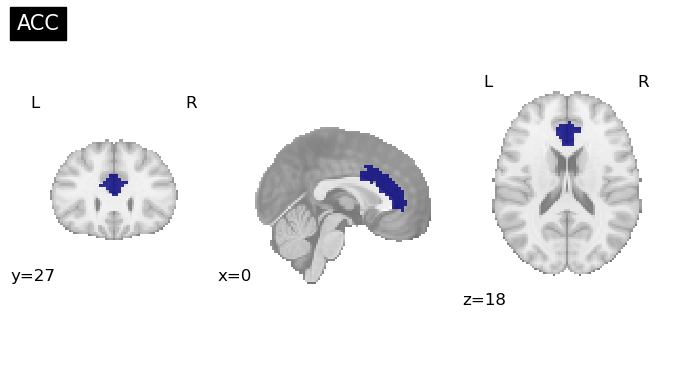

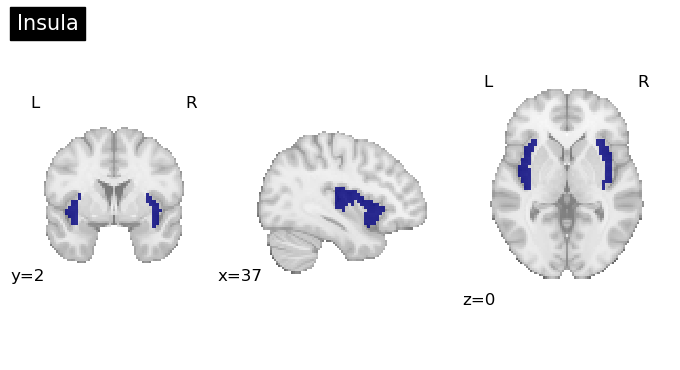

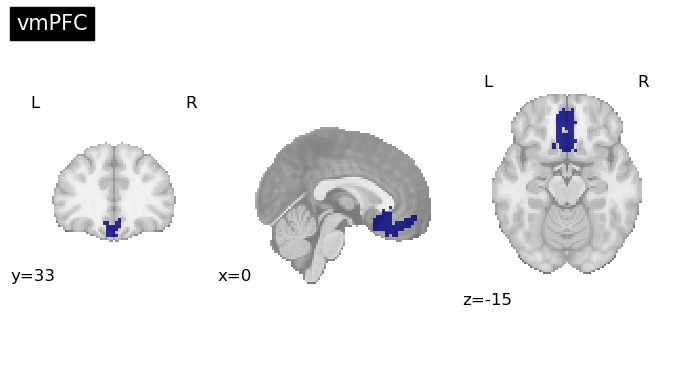

In [14]:
path = '/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/anatomically-constrained'
os.chdir(path)

# anatomically-constraining functional ROIs + lateralizing 
from nilearn.image import new_img_like
# right_amygdala = np.logical_and(amygdala_func.get_fdata(),right_amygdala_atlas.get_fdata())
# right_amygdala = right_amygdala.astype(int)
# right_amygdala = new_img_like(space_defining_image, right_amygdala)
# plotting.plot_roi(right_amygdala, draw_cross=False, alpha=0.8, title="Right Amygdala")
# nib.save(right_amygdala, 'right_amygdala.nii')

# left_amygdala = np.logical_and(amygdala_func.get_fdata(),left_amygdala_atlas.get_fdata())
# left_amygdala = left_amygdala.astype(int)
# left_amygdala = new_img_like(space_defining_image, left_amygdala)
# plotting.plot_roi(left_amygdala, draw_cross=False, alpha=0.8, title="Left Amygdala")
# nib.save(left_amygdala, 'left_amygdala.nii')

# right_hippocampus = np.logical_and(hippocampus_func.get_fdata(),right_hippocampus_atlas.get_fdata())
# right_hippocampus = right_hippocampus.astype(int)
# right_hippocampus = new_img_like(space_defining_image, right_hippocampus)
# plotting.plot_roi(right_hippocampus, draw_cross=False, alpha=0.8, title="Right Hippocampus")
# nib.save(right_hippocampus, 'right_hippocampus.nii')

# left_hippocampus = np.logical_and(hippocampus_func.get_fdata(),left_hippocampus_atlas.get_fdata())
# left_hippocampus = left_hippocampus.astype(int)
# left_hippocampus = new_img_like(space_defining_image, left_hippocampus)
# plotting.plot_roi(left_hippocampus, draw_cross=False, alpha=0.8, title="Left Hippocampus")
# nib.save(left_hippocampus, 'left_hippocampus.nii')

acc = np.logical_and(acc_func.get_fdata(),acc_atlas.get_fdata())
acc = acc.astype(int)
acc = new_img_like(space_defining_image, acc)
plotting.plot_roi(acc, draw_cross=False, alpha=0.8, title="ACC")
nib.save(acc, 'acc.nii')

insula = np.logical_and(insula_func.get_fdata(),insula_atlas.get_fdata())
insula = insula.astype(int)
insula = new_img_like(space_defining_image, insula)
plotting.plot_roi(insula, draw_cross=False, alpha=0.8, title="Insula")
nib.save(insula, 'insula.nii')

vmpfc1 = np.logical_and(vmpfc_func.get_fdata(),vmpfc1_atlas.get_fdata())
vmpfc1 = vmpfc1.astype(int)
vmpfc2 = np.logical_and(vmpfc_func.get_fdata(),vmpfc2_atlas.get_fdata())
vmpfc2 = vmpfc2.astype(int)
vmpfc = np.maximum.reduce([vmpfc1, vmpfc2])
vmpfc = new_img_like(space_defining_image, vmpfc)
plotting.plot_roi(vmpfc, draw_cross=False, alpha=0.8, title="vmPFC")
nib.save(vmpfc, 'vmpfc.nii')

### Combining ROI-mask for first-level (run to load in masker object)

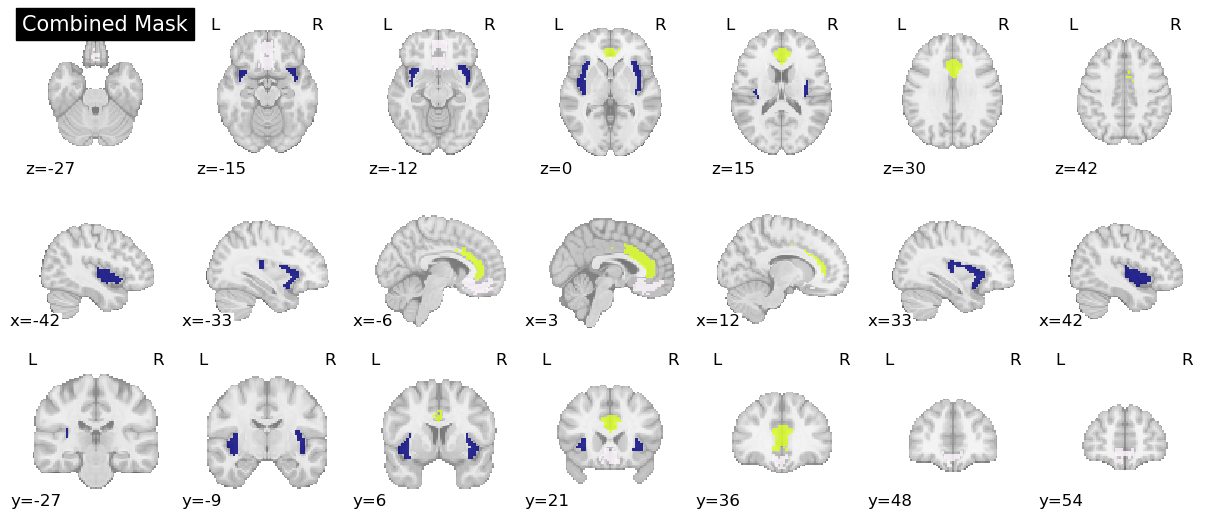

In [16]:
# run to load in previously-derived masks + create combined masker object (for ease of first-level computation)
from nilearn.maskers import NiftiLabelsMasker
from nibabel import Nifti1Image
from nilearn import plotting, masking

path = '/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/anatomically-constrained'
os.chdir(path)

#making space defining image
sub = 'N234'
fmri_imgs = layout.get(subject=sub,
                        datatype='func',
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
space_defining_image = masking.compute_brain_mask(fmri_imgs[0])

insula = nib.load('insula.nii')
acc = nib.load('acc.nii')
vmpfc = nib.load('vmpfc.nii')

insula_data = insula.get_fdata() * 1
acc_data = acc.get_fdata() * 2
vmpfc_data = vmpfc.get_fdata() * 3

# Combine the masks by taking the maximum value at each voxel
combined_mask_data = np.maximum.reduce([
    insula_data,
    acc_data,
    vmpfc_data
])

combined_mask_img = Nifti1Image(combined_mask_data, affine=insula.affine)
plotting.plot_roi(combined_mask_img, display_mode='mosaic',draw_cross=False, alpha=0.8, title="Combined Mask")

# First, initialize masker 
masker = NiftiLabelsMasker(
    combined_mask_img, mask_img=space_defining_image
)

### First Level 

In [17]:
# removing subjects w wrong sequence / missing phases: 
subjects = layout.get_subjects()
subjects1 = subjects
del(subjects1[0]) #sub101 has 2mm seq for phase 2, 3mm (correct) for phase 3
del(subjects1[49]) # sub201, has 2mm seq for phase 2, 3mm (correct) for phase 3 

subjects = layout.get_subjects()
subjects2 = subjects
del(subjects2[15]) #sub 120 missing phase 3

subjects = layout.get_subjects()

In [18]:
# can load in onsets (events.tsv) for all subs here as all subs have same task timings 
onsets_phase2 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events.xlsx',sheet_name=0)
onsets_phase3 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events.xlsx',sheet_name=1)
onsets_phase3_sub202 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events.xlsx',sheet_name=2)

onsets = onsets_phase2, onsets_phase3
onsets_sub202 = onsets_phase2, onsets_phase3_sub202

def load_bids_events(layout,onsets, subject, task, phaseno):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = layout.get_tr()
    # change lines below -- can change to "mask", change task to "self-other"
    func_files = layout.get(subject=subject,
                        datatype='func', task=task,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
    func_file = nimg.load_img(func_files)
    n_tr = func_file.shape[-1]
    onsets=onsets[phaseno]
    #onsets = pd.read_csv(layout_raw.get(subject=subject, suffix='events')[run].path, sep='\t') -- line to use if events changes by 
    
    # line below is isolating the onset, duration, and trial type columns -- change according to events.tsv format 
    onsets_actual = onsets.iloc[:, [0,1,3]]
    onsets_actual.columns = ['onset', 'duration','trial_type'] # make sure this order matches with what's loaded in as onsets 
    sampling_freq = 1/tr
    n_scans=n_tr
    return onsets_actual, tr, n_scans

In [19]:
# to iterate through subjects ... 
#for sub in subjects 
from scipy.stats import norm

p001_unc = norm.isf(0.001)

file_lists_phase2 = {"CSR-CSS": list(),
    "CSR-CS-": list(),
    "CSS-CS-": list(),
    "CSR-fix": list(),
    "CSS-fix": list(),
    "CSminus-fix": list()                 
    }

file_lists_phase3 = {"CSR-CSS": list(),
    "CSR-CS-": list(),
    "CSS-CS-": list(),
    "CSR-fix": list(),
    "CSS-fix": list(),
    "CSminus-fix": list()                 
    }

sub_order_phase2 = {"CSR-CSS": list(),
    "CSR-CS-": list(),
    "CSS-CS-": list(),
    "CSR-fix": list(),
    "CSS-fix": list(),
    "CSminus-fix": list()                 
    }

sub_order_phase3 = {"CSR-CSS": list(),
    "CSR-CS-": list(),
    "CSS-CS-": list(),
    "CSR-fix": list(),
    "CSS-fix": list(),
    "CSminus-fix": list()                 
    }

tasks = ['phase2','phase3']

for phaseno, task in enumerate(tasks): 

    if task == 'phase2':
        subject_list = subjects1 #CHANGE FROM NORMAL FIRST LEVEL -- ONLY TAKING SUBS WITH BOTH SES01 AND SES02 
    elif task == 'phase3':
        subject_list = subjects2        
    
    for sub in subject_list: 

# change lines below -- can change to "mask", change task to "self-other" -- should match the same format as in the load_bids_events function
        fmri_imgs = layout.get(subject=sub,
                        datatype='func', task=task,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
        hrf_model = "spm" #canonical hrf 
        high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

        dmn_time_series = []
        for con_img in fmri_imgs:
            dmn_time_series.append(masker.fit_transform(con_img))
        dmn_time_series = np.concatenate(dmn_time_series, axis = 0)
        
        confound_files = layout.get(subject=sub,
                            datatype='func', task=task,
                            desc='confounds',
                           extension="tsv",
                           return_type='file')
        # Select confounds 
        confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                           'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                             'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                             'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                             'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                             'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                             'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                             'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                        ]

        final_confounds = confound_vars

        design_matrices = []

        print("Creating First Level Design matrix ... ")

        if sub == 'N202':
            onsets_file = onsets_sub202 
        else:
            onsets_file = onsets
        
        for img in enumerate(fmri_imgs):
    # Build experimental paradigm
            events,tr,n_scans = load_bids_events(layout,onsets_file, sub, task, phaseno)
        # Define the sampling times for the design matrix
            frame_times = np.arange(n_scans) * tr
            confound_file = confound_files[0]
            confound_df = pd.read_csv(confound_file, delimiter='\t')
            confound_df = confound_df[final_confounds]
            confound_df.fillna(0, inplace=True)            
        # Build design matrix with the previously defined parameters
            design_matrix = make_first_level_design_matrix(
                frame_times,
                events,
                hrf_model=hrf_model,
                drift_model="polynomial",
                drift_order=3,
                add_regs=confound_df,
                add_reg_names=confound_vars,
                high_pass=high_pass,
            )

        design_matrices.append(design_matrix)
        design_matrix_allruns = []    
        design_matrix_allruns = np.concatenate(design_matrices, axis = 0)
            
        contrast_matrix = []
        contrast_matrix = np.eye(design_matrix.shape[1])
        basic_contrasts = {
            column: contrast_matrix[i]
            for i, column in enumerate(design_matrix.columns)
        }

        contrasts = {
            "CSR-CSS": (basic_contrasts["CSR"] - basic_contrasts["CSS"]),   
            "CSR-CS-": (basic_contrasts["CSR"] - basic_contrasts["CS-"]),   
            "CSS-CS-": (basic_contrasts["CSS"] - basic_contrasts["CS-"]), 
            "CSR-fix": (basic_contrasts["CSR"] - basic_contrasts["FIXATION"]),   
            "CSS-fix": (basic_contrasts["CSS"] - basic_contrasts["FIXATION"]),   
            "CSminus-fix": (basic_contrasts["CS-"] - basic_contrasts["FIXATION"]),            
        }

    #fmri_glm = FirstLevelModel()
        labels, estimates = run_glm(dmn_time_series, design_matrix_allruns)

        for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        
        # compute contrast-related statistics
            contrast = compute_contrast(labels, estimates, contrast_val)
            z_score = contrast.z_score()
            print(f"{contrast_id}: Z-score outputs: {z_score}") 
            
            if phaseno == 0:
                file_lists_phase2[contrast_id].append(contrast)
                sub_order_phase2[contrast_id].append('sub'+ sub + '-ses' + task)            

            else:
                file_lists_phase3[contrast_id].append(contrast)
                sub_order_phase3[contrast_id].append('sub'+ sub + '-ses' + task)            

        print("Subject = " + sub + " Completed!")

    

Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.81816107 -1.07778352 -0.98848179]
CSR-CS-: Z-score outputs: [ 0.51372151 -0.64354912 -1.38776484]
CSS-CS-: Z-score outputs: [ 1.3474015   0.49225463 -0.34984348]
CSR-fix: Z-score outputs: [-0.01785535 -1.38460821 -1.86336752]
CSS-fix: Z-score outputs: [ 1.01472742  0.0127223  -0.56069213]
CSminus-fix: Z-score outputs: [-0.72609333 -0.68013394 -0.13721608]
Subject = N103 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.90946108 1.23227222 0.19768562]
CSR-CS-: Z-score outputs: [ 0.2651334   2.74880157 -0.67166668]
CSS-CS-: Z-score outputs: [-1.76908899  1.39164978 -0.85033277]
CSR-fix: Z-score outputs: [ 0.59795471  0.92558973 -1.29042279]
CSS-fix: Z-score outputs: [-1.98378904 -0.76860689 -1.45368303]
CSminus-fix: Z-score outputs: [ 0.27916811 -2.82629098 -0.4906813 ]
Subject = N104 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.76568114 -2.68333789 -2.67877093]
CSR-CS-: Z-score outputs: [-0.40805973 -0.20604013 -0.34499676]
CSS-CS-: Z-score outputs: [0.41919525 2.62048641 2.49727783]
CSR-fix: Z-score outputs: [-0.56073775 -1.79202802 -2.827882  ]
CSS-fix: Z-score outputs: [0.48411377 1.8859058  0.87104362]
CSminus-fix: Z-score outputs: [-0.05190106 -1.67093033 -2.63643592]
Subject = N105 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.56861115 1.91642382 0.74332029]
CSR-CS-: Z-score outputs: [2.18836509 1.46001586 0.61566007]
CSS-CS-: Z-score outputs: [ 0.40927359 -0.69207419 -0.2098493 ]
CSR-fix: Z-score outputs: [0.94929943 0.61265167 0.6194911 ]
CSS-fix: Z-score outputs: [-1.16279553 -1.92732127 -0.39317546]
CSminus-fix: Z-score outputs: [-1.96775004 -1.33381025 -0.16823347]
Subject = N106 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.08743482 -1.0186494  -1.07365977]
CSR-CS-: Z-score outputs: [-1.10481497  0.78504852 -1.3091001 ]
CSS-CS-: Z-score outputs: [-1.18747514  1.86342222 -0.15446847]
CSR-fix: Z-score outputs: [ 0.10214352 -0.76918925 -1.35790204]
CSS-fix: Z-score outputs: [-0.01710216  0.61330429  0.1055391 ]
CSminus-fix: Z-score outputs: [ 1.66446288 -1.963313    0.3360699 ]
Subject = N108 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.02134681 -0.09794773  1.07158783]
CSR-CS-: Z-score outputs: [-2.09530908 -2.56666173 -1.6805272 ]
CSS-CS-: Z-score outputs: [-0.91545109 -2.39272059 -2.6803177 ]
CSR-fix: Z-score outputs: [-0.86864761  0.10477372  0.31993882]
CSS-fix: Z-score outputs: [ 0.47491443  0.22843621 -1.02642408]
CSminus-fix: Z-score outputs: [1.87543694 3.6179563  2.6086619 ]
Subject = N109 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [0.17952125 0.97715024 0.50853906]
CSR-CS-: Z-score outputs: [0.59292214 1.06521701 0.2101075 ]
CSS-CS-: Z-score outputs: [ 0.38834056  0.01727076 -0.3269015 ]
CSR-fix: Z-score outputs: [ 1.07630511  0.06813941 -1.179525  ]
CSS-fix: Z-score outputs: [ 0.80065545 -1.23153518 -1.81622981]
CSminus-fix: Z-score outputs: [ 0.36395939 -1.42889767 -1.59338324]
Subject = N110 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.93256421 -0.17452622 -0.3552953 ]
CSR-CS-: Z-score outputs: [-0.73658276 -1.00046538  0.11652415]
CSS-CS-: Z-score outputs: [ 0.30865752 -0.78368021  0.49689664]
CSR-fix: Z-score outputs: [-0.66583738 -0.44990405 -1.05761105]
CSS-fix: Z-score outputs: [ 0.60685241 -0.19912896 -0.54225351]
CSminus-fix: Z-score outputs: [ 0.27886449  0.90959121 -1.36383902]
Subject = N111 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.44799907 1.5741279  1.54038854]
CSR-CS-: Z-score outputs: [-1.04676593  0.36845319 -0.71851681]
CSS-CS-: Z-score outputs: [-2.50391698 -1.29589107 -2.3039004 ]
CSR-fix: Z-score outputs: [ 0.76122771  1.41817865 -0.09987917]
CSS-fix: Z-score outputs: [-1.21423874 -0.75799314 -2.1211404 ]
CSminus-fix: Z-score outputs: [2.26727587 1.02341642 0.89379683]
Subject = N112 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.02262412 0.68476308 0.62883897]
CSR-CS-: Z-score outputs: [-1.12746782 -0.20038395 -1.14802517]
CSS-CS-: Z-score outputs: [-2.07555123 -0.88220847 -1.69796928]
CSR-fix: Z-score outputs: [-0.67369999 -0.3386153  -0.9390268 ]
CSS-fix: Z-score outputs: [-1.93282567 -1.18719044 -1.6737243 ]
CSminus-fix: Z-score outputs: [ 0.81717371 -0.09401245  0.56092788]
Subject = N113 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.98479148 -0.22858288 -0.20673977]
CSR-CS-: Z-score outputs: [ 1.21050671  0.48305885 -0.08946259]
CSS-CS-: Z-score outputs: [2.20214455 0.70875979 0.13244162]
CSR-fix: Z-score outputs: [-1.03032962 -0.92015568  0.59973877]
CSS-fix: Z-score outputs: [ 0.32565838 -0.57961482  0.85159147]
CSminus-fix: Z-score outputs: [-2.80977042 -1.69864461  0.79121198]
Subject = N114 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.60394378 -0.731358    0.99255041]
CSR-CS-: Z-score outputs: [ 0.32294704 -1.14850846  1.25370143]
CSS-CS-: Z-score outputs: [-1.41762684 -0.33427699  0.16409715]
CSR-fix: Z-score outputs: [ 0.8339581  -2.05340378 -1.08469627]
CSS-fix: Z-score outputs: [-1.40051325 -1.04044044 -2.47170744]
CSminus-fix: Z-score outputs: [ 0.48423785 -0.68448743 -2.97242296]
Subject = N115 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.53884617 -1.38936489 -0.86709612]
CSR-CS-: Z-score outputs: [-0.40745292  0.94989096 -0.07851666]
CSS-CS-: Z-score outputs: [0.18984902 2.45846958 0.8631577 ]
CSR-fix: Z-score outputs: [ 0.19181914  0.6238918  -1.57511567]
CSS-fix: Z-score outputs: [ 0.92608881  2.48281765 -0.36356688]
CSminus-fix: Z-score outputs: [ 0.7899926  -0.61698788 -1.64784087]
Subject = N117 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.53915841  0.51183342  0.06210731]
CSR-CS-: Z-score outputs: [-0.73532817 -0.19469918 -1.17675914]
CSS-CS-: Z-score outputs: [-0.13436876 -0.72077836 -1.1722065 ]
CSR-fix: Z-score outputs: [-1.07145221 -0.23386158 -0.87296226]
CSS-fix: Z-score outputs: [-0.29367909 -0.88424    -0.88668598]
CSminus-fix: Z-score outputs: [-0.14752896  0.01481913  0.66414893]
Subject = N118 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.08460425  0.11241611 -0.41904758]
CSR-CS-: Z-score outputs: [ 0.16705172  0.49640116 -0.12101093]
CSS-CS-: Z-score outputs: [0.25283988 0.37761778 0.31974339]
CSR-fix: Z-score outputs: [ 0.0023637   0.0654339  -0.27655051]
CSS-fix: Z-score outputs: [ 0.1180428  -0.08787116  0.28419924]
CSminus-fix: Z-score outputs: [-0.23626151 -0.63830387 -0.13776171]
Subject = N120 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [0.68268428 0.18988787 1.04682486]
CSR-CS-: Z-score outputs: [0.96753138 0.68753648 1.50952957]
CSS-CS-: Z-score outputs: [0.24130487 0.47928888 0.38896678]
CSR-fix: Z-score outputs: [1.06792577 0.53920164 1.51993991]
CSS-fix: Z-score outputs: [0.12818556 0.27098691 0.0820101 ]
CSminus-fix: Z-score outputs: [-0.2016707  -0.38184515 -0.46448226]
Subject = N121 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.09195701 -0.3490101  -0.00846217]
CSR-CS-: Z-score outputs: [1.21768748 1.60426275 1.37191993]
CSS-CS-: Z-score outputs: [1.09007892 1.93909741 1.34842237]
CSR-fix: Z-score outputs: [-0.68247352 -0.73282712  0.71991185]
CSS-fix: Z-score outputs: [-0.7823448  -0.24808748  0.70972009]
CSminus-fix: Z-score outputs: [-2.45754621 -3.03110452 -1.13384092]
Subject = N122 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.72690995 -0.03306542  0.11373327]
CSR-CS-: Z-score outputs: [-1.62951971 -3.07579079 -1.08926317]
CSS-CS-: Z-score outputs: [-2.35473548 -2.96247513 -1.18891788]
CSR-fix: Z-score outputs: [-1.33458474 -1.96450853 -0.96668091]
CSS-fix: Z-score outputs: [-2.25322667 -1.83237416 -1.08759051]
CSminus-fix: Z-score outputs: [0.84718259 2.19128437 0.4932498 ]
Subject = N123 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.83464702 2.25715861 0.80369817]
CSR-CS-: Z-score outputs: [ 3.24398003  2.69762789 -1.04352537]
CSS-CS-: Z-score outputs: [ 1.21445423  0.2537855  -1.90568697]
CSR-fix: Z-score outputs: [ 2.79167879  2.2908234  -0.594827  ]
CSS-fix: Z-score outputs: [ 0.23958887 -0.81400616 -1.61196352]
CSminus-fix: Z-score outputs: [-1.47219429 -1.29810489  0.79792845]
Subject = N124 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.87492552 -0.82379648 -1.50402626]
CSR-CS-: Z-score outputs: [-0.68096157 -0.63496558  1.00997518]
CSS-CS-: Z-score outputs: [0.27401108 0.26170539 2.69851038]
CSR-fix: Z-score outputs: [-0.60658532 -1.51436569 -1.71707402]
CSS-fix: Z-score outputs: [ 0.5746888  -0.42138889  0.30947955]
CSminus-fix: Z-score outputs: [ 0.28354542 -0.89436584 -3.68767052]
Subject = N125 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.34927469  0.10164929  2.26902648]
CSR-CS-: Z-score outputs: [2.11256104 3.30643943 3.29056578]
CSS-CS-: Z-score outputs: [2.42107976 3.10431937 0.82763374]
CSR-fix: Z-score outputs: [0.48427657 1.41987212 1.86146483]
CSS-fix: Z-score outputs: [ 0.93621137  1.23131216 -1.24056373]
CSminus-fix: Z-score outputs: [-2.44070345 -3.09451954 -2.60027713]
Subject = N127 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.19560182  0.2833518   1.43284937]
CSR-CS-: Z-score outputs: [-0.5129826   0.57264127  2.86309644]
CSS-CS-: Z-score outputs: [0.80408595 0.27650485 1.3572161 ]
CSR-fix: Z-score outputs: [-0.82428967  0.82875582  1.97663669]
CSS-fix: Z-score outputs: [ 0.82583749  0.43006655 -0.02176287]
CSminus-fix: Z-score outputs: [-0.18784386  0.09024424 -1.97294498]
Subject = N128 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [0.65611951 1.18327758 1.51843224]
CSR-CS-: Z-score outputs: [3.16022666 2.65153244 0.57804752]
CSS-CS-: Z-score outputs: [ 2.35881243  1.32831432 -0.98779982]
CSR-fix: Z-score outputs: [-0.09868881 -0.58786562 -0.88562143]
CSS-fix: Z-score outputs: [-0.95777035 -2.11671841 -2.89072635]
CSminus-fix: Z-score outputs: [-4.39551198 -4.21571618 -1.70840911]
Subject = N129 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.66098729  0.38200771 -1.46630593]
CSR-CS-: Z-score outputs: [-3.20018737 -0.78336486  0.16145178]
CSS-CS-: Z-score outputs: [-2.38350616 -1.16163554  1.70727436]
CSR-fix: Z-score outputs: [-1.03092799 -0.30879026 -1.67184778]
CSS-fix: Z-score outputs: [-0.1080727  -0.80785754  0.34895231]
CSminus-fix: Z-score outputs: [ 3.32290811  0.75789548 -2.06343224]
Subject = N130 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-3.53568966 -2.98323072 -4.46396609]
CSR-CS-: Z-score outputs: [-1.90785086 -2.11541646 -2.68464939]
CSS-CS-: Z-score outputs: [1.83292425 1.02631148 2.01581406]
CSR-fix: Z-score outputs: [-2.33386961 -2.30523744 -4.4411448 ]
CSS-fix: Z-score outputs: [2.50000285 1.80428925 1.80081303]
CSminus-fix: Z-score outputs: [ 0.19079692  0.53214069 -0.91471203]
Subject = N131 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(


CSR-CSS: Z-score outputs: [0.96146117 1.01333771 0.30535746]
CSR-CS-: Z-score outputs: [0.88767098 1.34364964 1.17489683]
CSS-CS-: Z-score outputs: [-0.14819069  0.27954272  0.84478861]
CSR-fix: Z-score outputs: [ 1.33517896  1.2731333  -0.0713972 ]
CSS-fix: Z-score outputs: [ 0.0258299  -0.10221992 -0.47926062]
CSminus-fix: Z-score outputs: [ 0.24601377 -0.51985421 -1.78435834]
Subject = N132 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.47815852  0.22117113  0.53435066]
CSR-CS-: Z-score outputs: [1.31910623 0.6445578  0.90772852]
CSS-CS-: Z-score outputs: [1.77289436 0.36322169 0.28216099]
CSR-fix: Z-score outputs: [-0.1468004  -1.03620129 -0.67680259]
CSS-fix: Z-score outputs: [ 0.51149001 -1.28756681 -1.37533734]
CSminus-fix: Z-score outputs: [-2.02120491 -2.11079987 -2.03959931]
Subject = N133 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.79461743 -1.3146654  -1.62368293]
CSR-CS-: Z-score outputs: [ 0.18908791  0.12374627 -1.62217976]
CSS-CS-: Z-score outputs: [1.01605647 1.49754435 0.15849088]
CSR-fix: Z-score outputs: [-0.37299311 -1.4143902  -2.47578653]
CSS-fix: Z-score outputs: [ 0.70914777  0.42575222 -0.16842063]
CSminus-fix: Z-score outputs: [-0.6671895  -1.69813359 -0.42455222]
Subject = N134 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(


CSR-CSS: Z-score outputs: [-7.55734925e-01 -3.40365535e-04 -1.17036745e+00]
CSR-CS-: Z-score outputs: [-0.66031389 -0.99313829 -3.32640145]
CSS-CS-: Z-score outputs: [ 0.15547321 -0.94663308 -1.87893628]
CSR-fix: Z-score outputs: [-1.60119306 -1.54416223 -3.91576683]
CSS-fix: Z-score outputs: [-0.49665327 -1.44891991 -2.13033039]
CSminus-fix: Z-score outputs: [-0.77704798 -0.28202623  0.19364   ]
Subject = N135 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.20698854  0.86852955  0.48949142]
CSR-CS-: Z-score outputs: [-0.86288898 -1.62230111 -1.26604253]
CSS-CS-: Z-score outputs: [ 0.44716933 -2.51356243 -1.76499169]
CSR-fix: Z-score outputs: [-1.16517124 -1.59675447 -1.33630827]
CSS-fix: Z-score outputs: [ 0.48309533 -2.69688002 -1.95427273]
CSminus-fix: Z-score outputs: [-0.0843471   0.49524983  0.3031327 ]
Subject = N136 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 2.12757708  1.50089912 -0.42907205]
CSR-CS-: Z-score outputs: [ 0.44231662  1.07018662 -1.26327964]
CSS-CS-: Z-score outputs: [-1.71804723 -0.50514933 -0.76994135]
CSR-fix: Z-score outputs: [ 1.69522026  1.94001585 -0.68419141]
CSS-fix: Z-score outputs: [-1.2362335  -0.15790863 -0.07423242]
CSminus-fix: Z-score outputs: [1.13957011 0.55795976 1.0400501 ]
Subject = N137 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.57683221 0.35609133 0.47681211]
CSR-CS-: Z-score outputs: [ 0.62469636  0.0288774  -0.45456452]
CSS-CS-: Z-score outputs: [-1.07335289 -0.35359049 -0.94316307]
CSR-fix: Z-score outputs: [ 1.25370404 -0.29459274 -0.72549481]
CSS-fix: Z-score outputs: [-0.90834855 -0.74603216 -1.33819923]
CSminus-fix: Z-score outputs: [ 0.49603916 -0.36609209 -0.13128497]
Subject = N138 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.01813875  0.32118259  1.01541426]
CSR-CS-: Z-score outputs: [ 0.13653262 -1.15853531 -0.01377631]
CSS-CS-: Z-score outputs: [ 0.15449983 -1.49070816 -1.07855861]
CSR-fix: Z-score outputs: [-0.8969911  -2.79594869 -2.13482286]
CSS-fix: Z-score outputs: [-0.84846161 -3.17343556 -3.40241819]
CSminus-fix: Z-score outputs: [-1.17844546 -1.3799437  -2.32659028]
Subject = N141 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [2.52660674 2.93184522 1.19487011]
CSR-CS-: Z-score outputs: [2.12208895 2.6165774  1.3635331 ]
CSS-CS-: Z-score outputs: [-0.66033779 -0.56759069  0.03115307]
CSR-fix: Z-score outputs: [1.58585392 1.27116238 1.03890155]
CSS-fix: Z-score outputs: [-1.85832295 -2.72760447 -0.59204078]
CSminus-fix: Z-score outputs: [-1.21226212 -2.29908677 -0.7452893 ]
Subject = N142 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.01724502 -0.45671208  0.03147071]
CSR-CS-: Z-score outputs: [-0.87204755  0.31677908 -0.39285929]
CSS-CS-: Z-score outputs: [-0.87599347  0.78886982 -0.40681285]
CSR-fix: Z-score outputs: [-0.08354835  0.37678642 -0.5396512 ]
CSS-fix: Z-score outputs: [-0.10487803  0.97974379 -0.54704803]
CSminus-fix: Z-score outputs: [ 1.1296221  -0.03554447 -0.06959484]
Subject = N143 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.39399219  0.07675982 -0.0408571 ]
CSR-CS-: Z-score outputs: [-0.56146413  0.8745132   0.28813469]
CSS-CS-: Z-score outputs: [-0.11339537  0.74384509  0.31887146]
CSR-fix: Z-score outputs: [-2.04146673 -2.06323734 -0.93952618]
CSS-fix: Z-score outputs: [-1.40097671 -2.02651152 -0.83884615]
CSminus-fix: Z-score outputs: [-1.4695396  -3.4384313  -1.40400491]
Subject = N144 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.27755086 0.11085799 0.03301733]
CSR-CS-: Z-score outputs: [-0.96971245 -1.43596665 -0.11656584]
CSS-CS-: Z-score outputs: [-2.3393732  -1.52608953 -0.15038671]
CSR-fix: Z-score outputs: [ 0.22787737 -1.1165806  -0.51560173]
CSS-fix: Z-score outputs: [-1.48756578 -1.22966897 -0.55011009]
CSminus-fix: Z-score outputs: [ 1.63019389  0.7296338  -0.42468556]
Subject = N145 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.16913836 -0.82167822 -1.72462312]
CSR-CS-: Z-score outputs: [ 0.80926449 -0.99354644 -2.54252778]
CSS-CS-: Z-score outputs: [ 0.97966669 -0.06115391 -0.58825717]
CSR-fix: Z-score outputs: [ 0.54632394 -0.51067864 -1.64446292]
CSS-fix: Z-score outputs: [0.75261968 0.62857297 0.77853243]
CSminus-fix: Z-score outputs: [-0.54782134  0.83568967  1.77212154]
Subject = N146 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.78873543 -1.60528555  0.69069611]
CSR-CS-: Z-score outputs: [-2.87718505 -2.61820359 -1.03311126]
CSS-CS-: Z-score outputs: [-0.95464705 -0.8502181  -1.70313728]
CSR-fix: Z-score outputs: [-2.04765797 -1.86964075 -0.90498151]
CSS-fix: Z-score outputs: [ 0.38319156  0.3062428  -1.74291415]
CSminus-fix: Z-score outputs: [1.81563662 1.59834462 0.43781574]
Subject = N147 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(


CSR-CSS: Z-score outputs: [0.10269317 0.71149674 0.64141158]
CSR-CS-: Z-score outputs: [1.71967666 0.21927171 1.08835521]
CSS-CS-: Z-score outputs: [ 1.60636549 -0.52390393  0.38797697]
CSR-fix: Z-score outputs: [1.36810548 0.49551455 0.11476242]
CSS-fix: Z-score outputs: [ 1.22550787 -0.46286113 -0.73174443]
CSminus-fix: Z-score outputs: [-0.97346856  0.23654877 -1.4307207 ]
Subject = N148 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.24518292  0.02943175  1.36599714]
CSR-CS-: Z-score outputs: [ 1.31265293 -0.02823994  0.25060046]
CSS-CS-: Z-score outputs: [ 1.5460968  -0.05867403 -1.19360901]
CSR-fix: Z-score outputs: [ 0.9378384   0.18500145 -1.56564714]
CSS-fix: Z-score outputs: [ 1.22715793  0.13941393 -3.27874727]
CSminus-fix: Z-score outputs: [-0.79754476  0.23617403 -2.01577616]
Subject = N149 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-2.71364556 -1.56945114  0.16316673]
CSR-CS-: Z-score outputs: [-0.39170959 -1.67394992 -3.48755604]
CSS-CS-: Z-score outputs: [ 2.55725804  0.03361721 -3.63986682]
CSR-fix: Z-score outputs: [-0.74180305 -1.37142431 -2.52008413]
CSS-fix: Z-score outputs: [ 3.00711771  0.7889208  -2.75535182]
CSminus-fix: Z-score outputs: [-0.27678642  0.82794043  2.08176427]
Subject = N150 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(


CSR-CSS: Z-score outputs: [-1.74333466 -2.91069366 -1.7806866 ]
CSR-CS-: Z-score outputs: [-2.54884954 -1.65291398 -0.23604888]
CSS-CS-: Z-score outputs: [-0.70125603  1.39112985  1.59787527]
CSR-fix: Z-score outputs: [-1.38731922 -2.00011755 -1.34463293]
CSS-fix: Z-score outputs: [0.96912479 1.9270016  1.04922011]
CSminus-fix: Z-score outputs: [ 1.93929223  0.13796652 -1.04350641]
Subject = N151 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.26843118 1.99324466 1.99281217]
CSR-CS-: Z-score outputs: [2.96019824 2.87786467 1.67193834]
CSS-CS-: Z-score outputs: [ 1.469714    0.66352123 -0.53074986]
CSR-fix: Z-score outputs: [1.28388703 1.91004067 1.36306843]
CSS-fix: Z-score outputs: [-0.49111925 -0.86931761 -1.38624638]
CSminus-fix: Z-score outputs: [-2.73776609 -1.96589846 -0.85420388]
Subject = N153 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.2372886  -1.33267122 -0.71757166]
CSR-CS-: Z-score outputs: [1.28837041 1.34616862 0.46890666]
CSS-CS-: Z-score outputs: [0.99003256 2.70679347 1.21590268]
CSR-fix: Z-score outputs: [ 0.90133343  0.40694585 -1.98952392]
CSS-fix: Z-score outputs: [ 0.55095733  2.19376235 -0.93538479]
CSminus-fix: Z-score outputs: [-0.79527355 -1.43352434 -2.91079426]
Subject = N154 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [0.32503877 1.2297225  0.78685684]
CSR-CS-: Z-score outputs: [0.96301456 1.61513552 0.79701329]
CSS-CS-: Z-score outputs: [ 0.61209361  0.28325238 -0.06143419]
CSR-fix: Z-score outputs: [0.81275509 1.1901708  0.21546697]
CSS-fix: Z-score outputs: [ 0.34999991 -0.50514764 -0.84544144]
CSminus-fix: Z-score outputs: [-0.48389179 -0.97763316 -0.88674819]
Subject = N155 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.36222055  0.31641105 -1.31727934]
CSR-CS-: Z-score outputs: [ 0.78693637  0.82082401 -0.06526622]
CSS-CS-: Z-score outputs: [-0.65267236  0.47105711  1.30310837]
CSR-fix: Z-score outputs: [ 0.58737278  0.70598799 -1.14677433]
CSS-fix: Z-score outputs: [-1.28624313  0.25509346  0.68286541]
CSminus-fix: Z-score outputs: [-0.47829102 -0.40294272 -1.13901758]
Subject = N156 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.77189754 -1.06594544 -0.17642014]
CSR-CS-: Z-score outputs: [-0.99484554 -1.95009415 -1.15018683]
CSS-CS-: Z-score outputs: [-0.15160026 -0.77333108 -0.92720504]
CSR-fix: Z-score outputs: [-0.44142271 -1.76472856 -0.36234918]
CSS-fix: Z-score outputs: [ 0.61988321 -0.23652331 -0.10535841]
CSminus-fix: Z-score outputs: [0.91867399 0.85883453 1.22452715]
Subject = N157 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.08357473 -0.33749793  1.11830955]
CSR-CS-: Z-score outputs: [0.89476202 0.81939574 0.72472117]
CSS-CS-: Z-score outputs: [-0.29670686  1.11914105 -0.51365941]
CSR-fix: Z-score outputs: [ 0.81190327  0.34854593 -0.80697335]
CSS-fix: Z-score outputs: [-0.69167137  0.77519749 -2.21442697]
CSminus-fix: Z-score outputs: [-0.36522066 -0.76144883 -1.90315456]
Subject = N158 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.34432796 -0.58536849 -0.33198491]
CSR-CS-: Z-score outputs: [ 0.05868194 -1.19990394 -2.66533899]
CSS-CS-: Z-score outputs: [ 0.4235246  -0.54385242 -2.23043409]
CSR-fix: Z-score outputs: [-1.16112123 -2.04672293 -2.65569871]
CSS-fix: Z-score outputs: [-0.65549715 -1.18476096 -2.09111303]
CSminus-fix: Z-score outputs: [-1.37206619 -0.5955287   0.77596705]
Subject = N202 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.51975823 0.97739706 1.02546894]
CSR-CS-: Z-score outputs: [-0.92194969  0.45026927  0.30852187]
CSS-CS-: Z-score outputs: [-2.48976037 -0.58135318 -0.78591172]
CSR-fix: Z-score outputs: [ 0.82741097 -0.22110998 -0.53849214]
CSS-fix: Z-score outputs: [-1.24499851 -1.52142108 -1.86604272]
CSminus-fix: Z-score outputs: [ 2.16205197 -0.8645571  -1.00760177]
Subject = N203 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(


CSR-CSS: Z-score outputs: [-1.45557856 -1.18145565  0.19909902]
CSR-CS-: Z-score outputs: [-0.93208155 -1.54398357 -0.70236098]
CSS-CS-: Z-score outputs: [ 0.66998178 -0.1775866  -0.86794089]
CSR-fix: Z-score outputs: [-0.37843676 -0.79669952 -1.32917119]
CSS-fix: Z-score outputs: [ 1.56839984  0.80475002 -1.51113792]
CSminus-fix: Z-score outputs: [ 0.89165169  1.27380606 -0.53976325]
Subject = N204 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.36609806  0.71027133 -1.5361999 ]
CSR-CS-: Z-score outputs: [1.42096573 1.87105883 0.88783955]
CSS-CS-: Z-score outputs: [2.80576307 1.08456688 2.45088363]
CSR-fix: Z-score outputs: [ 0.54988016  1.61680274 -0.16525952]
CSS-fix: Z-score outputs: [2.38001227 0.60847084 1.96055408]
CSminus-fix: Z-score outputs: [-1.42284398 -0.87441487 -1.43862671]
Subject = N206 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.07403841  0.46200274 -0.173534  ]
CSR-CS-: Z-score outputs: [-0.32566155 -0.45449592 -1.10013816]
CSS-CS-: Z-score outputs: [-0.23953051 -0.94017889 -0.87552073]
CSR-fix: Z-score outputs: [ 0.03312832  0.71993973 -1.49549104]
CSS-fix: Z-score outputs: [ 0.13141089  0.07492329 -1.16768221]
CSminus-fix: Z-score outputs: [ 0.49581323  1.42438628 -0.17355985]
Subject = N207 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.50244332 -0.90123159 -0.98071282]
CSR-CS-: Z-score outputs: [-0.1828887  -0.17715781 -0.74792108]
CSS-CS-: Z-score outputs: [0.35678398 0.80734669 0.34036969]
CSR-fix: Z-score outputs: [-0.52828439  0.0072604  -1.05073232]
CSS-fix: Z-score outputs: [0.15203564 1.16254236 0.2740537 ]
CSminus-fix: Z-score outputs: [-0.34031525  0.26161578 -0.16561034]
Subject = N209 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.43802297  0.80098312  1.29883662]
CSR-CS-: Z-score outputs: [4.09216262 4.28497186 0.05057898]
CSS-CS-: Z-score outputs: [ 4.32672059  3.2210735  -1.31172158]
CSR-fix: Z-score outputs: [3.00262085 3.534815   0.48951521]
CSS-fix: Z-score outputs: [ 3.32239314  2.21395606 -1.25590539]
CSminus-fix: Z-score outputs: [-2.51753592 -2.14880589  0.46379465]
Subject = N210 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.92660961 -1.2399079  -0.5703947 ]
CSR-CS-: Z-score outputs: [-1.38761577 -1.26946744 -1.16059223]
CSS-CS-: Z-score outputs: [-0.39877575  0.02823014 -0.55119633]
CSR-fix: Z-score outputs: [-2.74397202 -2.23763239 -1.18526871]
CSS-fix: Z-score outputs: [-1.44333183 -0.52751744 -0.39429854]
CSminus-fix: Z-score outputs: [-1.08767123 -0.63307394  0.34329627]
Subject = N211 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.19519567 -1.12205401  0.34813217]
CSR-CS-: Z-score outputs: [2.28803198 1.41758611 0.07527346]
CSS-CS-: Z-score outputs: [ 2.42882379  2.55081161 -0.28644433]
CSR-fix: Z-score outputs: [ 1.12070017 -0.46272429 -0.1911346 ]
CSS-fix: Z-score outputs: [ 1.33281389  1.0483767  -0.65636704]
CSminus-fix: Z-score outputs: [-1.96885052 -2.4817673  -0.31092448]
Subject = N212 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 2.98969966  1.37381695 -0.01556783]
CSR-CS-: Z-score outputs: [2.72844483 1.93801054 3.14895463]
CSS-CS-: Z-score outputs: [-0.48051041  0.4996069   3.21992454]
CSR-fix: Z-score outputs: [ 1.12163234 -0.26889836  0.86514702]
CSS-fix: Z-score outputs: [-2.98113739 -2.13592885  0.86634529]
CSminus-fix: Z-score outputs: [-2.68121475 -3.04225723 -3.5796261 ]
Subject = N213 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.59734976  0.80466773 -2.52127678]
CSR-CS-: Z-score outputs: [-0.39801052  1.73344788 -0.96040057]
CSS-CS-: Z-score outputs: [-1.00208624  0.86186368  1.74187156]
CSR-fix: Z-score outputs: [ 1.5557781   3.21227867 -1.34230602]
CSS-fix: Z-score outputs: [0.71201925 2.06631275 2.0859637 ]
CSminus-fix: Z-score outputs: [ 2.19791975  1.0045934  -0.13963765]
Subject = N214 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.48676201 -0.61424191 -4.96599081]
CSR-CS-: Z-score outputs: [ 2.06640858 -0.97541042 -5.79170536]
CSS-CS-: Z-score outputs: [ 0.41368645 -0.28218648 -0.30175245]
CSR-fix: Z-score outputs: [ 2.12332131 -0.23284823 -5.23219109]
CSS-fix: Z-score outputs: [0.0531711  0.60337593 1.65956205]
CSminus-fix: Z-score outputs: [-0.53378923  1.10553746  2.34770106]
Subject = N215 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 1.05836914 -0.33191581  0.66659112]
CSR-CS-: Z-score outputs: [ 0.62558383 -0.32978975 -1.68020314]
CSS-CS-: Z-score outputs: [-0.4955987   0.02253312 -2.30653359]
CSR-fix: Z-score outputs: [ 0.17582992  0.10774791 -0.48513847]
CSS-fix: Z-score outputs: [-1.25705351  0.55859587 -1.35314275]
CSminus-fix: Z-score outputs: [-0.65050352  0.5522543   1.72428259]
Subject = N216 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.83858463 -1.14893253  0.71713368]
CSR-CS-: Z-score outputs: [-0.38698457 -0.63418748  0.40323749]
CSS-CS-: Z-score outputs: [ 0.47223173  0.55268233 -0.32873329]
CSR-fix: Z-score outputs: [ 0.32012526 -0.58730762 -0.59876238]
CSS-fix: Z-score outputs: [ 1.42107641  0.94910191 -1.54529003]
CSminus-fix: Z-score outputs: [ 0.85594285  0.23958309 -1.16036773]
Subject = N217 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.74640902  1.58434953  0.45678581]
CSR-CS-: Z-score outputs: [0.55393361 2.49682279 1.48055844]
CSS-CS-: Z-score outputs: [1.33129489 0.82811212 0.98002432]
CSR-fix: Z-score outputs: [0.35997552 1.71738551 0.74824833]
CSS-fix: Z-score outputs: [ 1.3548999  -0.41273147  0.13097884]
CSminus-fix: Z-score outputs: [-0.39736889 -1.66770726 -1.2769511 ]
Subject = N219 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-2.55357088 -0.23323981 -2.18320115]
CSR-CS-: Z-score outputs: [1.28642013 2.53253736 0.08254434]
CSS-CS-: Z-score outputs: [3.96102198 2.71553975 2.42282532]
CSR-fix: Z-score outputs: [-0.43492643  0.61189288 -0.83524068]
CSS-fix: Z-score outputs: [3.05759411 0.90710034 2.16588518]
CSminus-fix: Z-score outputs: [-2.34455619 -2.97607143 -1.06614512]
Subject = N220 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [2.41082862 1.12258133 0.96054636]
CSR-CS-: Z-score outputs: [ 1.49519807  1.37951356 -0.05485421]
CSS-CS-: Z-score outputs: [-1.11424595  0.15470075 -1.05835469]
CSR-fix: Z-score outputs: [ 1.0728427   0.21799373 -0.68944776]
CSS-fix: Z-score outputs: [-2.20130785 -1.30021952 -1.9619977 ]
CSminus-fix: Z-score outputs: [-0.9137418  -1.68404119 -0.66416139]
Subject = N221 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.56074782  0.37063271 -0.2512724 ]
CSR-CS-: Z-score outputs: [-0.40503447 -0.62441148  0.15003656]
CSS-CS-: Z-score outputs: [ 0.20640187 -1.00555465  0.41281282]
CSR-fix: Z-score outputs: [ 0.17595414  0.46274016 -0.69075709]
CSS-fix: Z-score outputs: [ 0.92537345 -0.05376107 -0.33436282]
CSminus-fix: Z-score outputs: [ 0.76933145  1.38374049 -0.96103593]
Subject = N222 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.37947381 -0.11785118  0.01977534]
CSR-CS-: Z-score outputs: [ 1.13887050e+00  8.80953723e-04 -1.81012526e+00]
CSS-CS-: Z-score outputs: [ 1.49899733  0.12959555 -1.76232773]
CSR-fix: Z-score outputs: [ 0.68088176 -1.09810221 -3.40356359]
CSS-fix: Z-score outputs: [ 1.15973857 -0.89721366 -3.30309363]
CSminus-fix: Z-score outputs: [-0.8223928  -1.25239343 -1.35135488]
Subject = N224 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.06603236  1.70121523 -0.2376301 ]
CSR-CS-: Z-score outputs: [-0.32329097  0.23273562 -0.93159999]
CSS-CS-: Z-score outputs: [-0.38783204 -1.60826508 -0.66023738]
CSR-fix: Z-score outputs: [ 0.81530434  0.83289162 -0.81701102]
CSS-fix: Z-score outputs: [ 0.70696383 -1.45959059 -0.48033472]
CSminus-fix: Z-score outputs: [1.40399244 0.63235868 0.40434799]
Subject = N225 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.00212203 -0.08654229  1.87802833]
CSR-CS-: Z-score outputs: [2.05430716 1.6200051  0.71692375]
CSS-CS-: Z-score outputs: [ 2.0027598   1.68059397 -1.36105971]
CSR-fix: Z-score outputs: [ 0.92251089  0.4162703  -0.88374788]
CSS-fix: Z-score outputs: [ 0.85008163  0.50137043 -3.10205206]
CSminus-fix: Z-score outputs: [-1.83063334 -1.78932805 -1.96276673]
Subject = N226 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.74660465 0.71029207 1.15968899]
CSR-CS-: Z-score outputs: [ 1.18413699  0.0141501  -0.08317477]
CSS-CS-: Z-score outputs: [-0.65973105 -0.72194425 -1.28453781]
CSR-fix: Z-score outputs: [ 1.06460742 -0.35200749 -0.70244692]
CSS-fix: Z-score outputs: [-1.25436357 -1.268197   -2.18548439]
CSminus-fix: Z-score outputs: [-0.51690438 -0.4167236  -0.67085338]
Subject = N227 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.72152502 1.66264968 0.07182519]
CSR-CS-: Z-score outputs: [-0.87627065  0.44347608 -0.43266664]
CSS-CS-: Z-score outputs: [-2.6318703  -1.3191609  -0.49709906]
CSR-fix: Z-score outputs: [-0.90546093 -0.65648221 -2.43843289]
CSS-fix: Z-score outputs: [-3.11342349 -2.80088822 -2.44993745]
CSminus-fix: Z-score outputs: [ 0.23613167 -1.35304927 -2.00782591]
Subject = N228 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.45457195 -1.50896618 -0.61141297]
CSR-CS-: Z-score outputs: [-0.07549117 -0.15691149 -0.82813314]
CSS-CS-: Z-score outputs: [ 1.47703369  1.47211482 -0.15953964]
CSR-fix: Z-score outputs: [-0.64767155  0.51262292 -0.01806808]
CSS-fix: Z-score outputs: [1.34747335 2.5307261  0.81562374]
CSminus-fix: Z-score outputs: [-0.61328722  0.8014961   1.15378739]
Subject = N230 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.69451646 -0.31347807  0.05852202]
CSR-CS-: Z-score outputs: [-2.9864031  -2.40260991 -0.46312471]
CSS-CS-: Z-score outputs: [-2.27933844 -2.08854787 -0.52830272]
CSR-fix: Z-score outputs: [-1.77429578 -1.90357372 -1.67797008]
CSS-fix: Z-score outputs: [-0.81252352 -1.45251135 -1.72615126]
CSminus-fix: Z-score outputs: [ 2.3397155   1.34970417 -1.20182385]
Subject = N231 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.951651    1.4680171  -1.70605324]
CSR-CS-: Z-score outputs: [ 1.37891849  1.51879489 -2.62149645]
CSS-CS-: Z-score outputs: [ 0.32927273 -0.06251708 -0.6941083 ]
CSR-fix: Z-score outputs: [ 3.37485488  3.66935178 -3.87899234]
CSS-fix: Z-score outputs: [ 1.97709591  1.5777885  -1.4375035 ]
CSminus-fix: Z-score outputs: [ 1.72580227  1.80858714 -0.64378123]
Subject = N232 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.47397141 0.8645414  0.69117921]
CSR-CS-: Z-score outputs: [2.36962327 0.94065651 1.06799794]
CSS-CS-: Z-score outputs: [0.79863124 0.02109689 0.31842057]
CSR-fix: Z-score outputs: [ 1.11881645  0.24707982 -0.0079001 ]
CSS-fix: Z-score outputs: [-0.85738982 -0.89238013 -0.89663172]
CSminus-fix: Z-score outputs: [-2.10447206 -1.04744112 -1.49464089]
Subject = N233 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.05585259  0.85629344 -1.46725178]
CSR-CS-: Z-score outputs: [ 0.4802716   1.46501954 -1.10810308]
CSS-CS-: Z-score outputs: [-0.68169439  0.56722351  0.49511715]
CSR-fix: Z-score outputs: [ 2.32980435  1.56738043 -2.95062127]
CSS-fix: Z-score outputs: [ 0.94621524  0.43300249 -1.04585964]
CSminus-fix: Z-score outputs: [ 2.15810186 -0.308368   -2.04132257]
Subject = N234 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [0.61712013 1.02718974 0.83045526]
CSR-CS-: Z-score outputs: [2.08828388 2.04983827 0.71673115]
CSS-CS-: Z-score outputs: [ 1.38520299  0.91341028 -0.20895497]
CSR-fix: Z-score outputs: [0.89769394 1.26596053 0.25249598]
CSS-fix: Z-score outputs: [ 0.05926625 -0.12363184 -0.83878136]
CSminus-fix: Z-score outputs: [-1.93902222 -1.46810916 -0.72737482]
Subject = N235 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.63574854 -0.06986905  2.2747215 ]
CSR-CS-: Z-score outputs: [ 0.86073927  0.06563189 -0.05245032]
CSS-CS-: Z-score outputs: [ 1.48677032  0.13629526 -2.45688342]
CSR-fix: Z-score outputs: [0.49726367 1.00529091 1.82932834]
CSS-fix: Z-score outputs: [ 1.29390787  1.04422843 -1.27791263]
CSminus-fix: Z-score outputs: [-0.63549809  1.00002293  2.08080885]
Subject = N236 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.57846904 -0.0367299  -1.1880332 ]
CSR-CS-: Z-score outputs: [ 0.64493676 -0.59717589 -1.43945785]
CSS-CS-: Z-score outputs: [ 0.01030898 -0.57103903 -0.11536932]
CSR-fix: Z-score outputs: [ 1.05097081  0.17867509 -2.35649899]
CSS-fix: Z-score outputs: [ 0.29138768  0.2364659  -0.80655888]
CSminus-fix: Z-score outputs: [ 0.32460634  1.0940558  -0.7946322 ]
Subject = N237 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.96707359  0.49114678  1.56275225]
CSR-CS-: Z-score outputs: [-0.94351626  0.11999939  2.05477984]
CSS-CS-: Z-score outputs: [ 0.09810136 -0.40158973  0.35754622]
CSR-fix: Z-score outputs: [0.37224025 0.85161004 1.61431495]
CSS-fix: Z-score outputs: [ 1.65941373  0.17327647 -0.5213153 ]
CSminus-fix: Z-score outputs: [ 1.68603715  0.7492039  -1.07395918]
Subject = N238 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-3.05167489 -1.76605443 -1.75384264]
CSR-CS-: Z-score outputs: [-1.50153208  0.30013581 -0.85225548]
CSS-CS-: Z-score outputs: [1.76820662 2.16670509 1.06600884]
CSR-fix: Z-score outputs: [-2.7121431  -1.26880745 -1.51547211]
CSS-fix: Z-score outputs: [1.49509745 1.14205213 0.8880803 ]
CSminus-fix: Z-score outputs: [-0.83816659 -1.81157364 -0.48333043]
Subject = N240 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.21623238 -0.12946333 -2.1836106 ]
CSR-CS-: Z-score outputs: [ 1.57775785  0.46452536 -3.22401662]
CSS-CS-: Z-score outputs: [ 1.80342545  0.60165889 -0.85465601]
CSR-fix: Z-score outputs: [ 1.42559346 -0.76340556 -3.39569978]
CSS-fix: Z-score outputs: [ 1.66281316 -0.56408445 -0.4111485 ]
CSminus-fix: Z-score outputs: [-0.66591299 -1.50172532  0.74666497]
Subject = N241 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.99415884 -1.94058788  1.7287301 ]
CSR-CS-: Z-score outputs: [0.67962339 0.01180135 1.10703766]
CSS-CS-: Z-score outputs: [ 1.7097723   2.05812228 -0.82998877]
CSR-fix: Z-score outputs: [-0.36103013 -1.36508222  0.23043122]
CSS-fix: Z-score outputs: [ 0.95964831  1.26325279 -2.01040433]
CSminus-fix: Z-score outputs: [-1.32953861 -1.49586367 -1.23727474]
Subject = N242 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.21481185 -1.50830464 -0.33899577]
CSR-CS-: Z-score outputs: [ 0.36748903  0.24912184 -1.13450764]
CSS-CS-: Z-score outputs: [ 1.58653388  1.77264858 -0.73963983]
CSR-fix: Z-score outputs: [-0.48634791 -1.46374231 -2.31022605]
CSS-fix: Z-score outputs: [ 1.12275057  0.5929528  -1.73548476]
CSminus-fix: Z-score outputs: [-1.04656464 -1.92794916 -0.92030032]
Subject = N243 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.81721805 4.27235713 2.68245461]
CSR-CS-: Z-score outputs: [ 0.55591411  1.42462338 -0.51114213]
CSS-CS-: Z-score outputs: [-1.4032318  -3.22397214 -3.39152984]
CSR-fix: Z-score outputs: [ 1.51415835  2.96610785 -0.14362918]
CSS-fix: Z-score outputs: [-0.96455943 -2.87118934 -3.62078889]
CSminus-fix: Z-score outputs: [0.88374199 1.28111206 0.55600131]
Subject = N244 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.68922424  0.83878294 -0.41474236]
CSR-CS-: Z-score outputs: [1.65979889 1.85258951 0.47976738]
CSS-CS-: Z-score outputs: [0.90555554 0.9340981  0.8857278 ]
CSR-fix: Z-score outputs: [0.38340781 1.13792858 0.04901512]
CSS-fix: Z-score outputs: [-0.55697748 -0.03276836  0.601746  ]
CSminus-fix: Z-score outputs: [-1.91264754 -1.38400262 -0.61731364]
Subject = N246 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.3736449  -1.73710715  0.01560686]
CSR-CS-: Z-score outputs: [-0.24286579 -0.08771964  1.45441124]
CSS-CS-: Z-score outputs: [1.24693517 1.8047622  1.42712333]
CSR-fix: Z-score outputs: [-1.73386295 -2.97628666  0.14636724]
CSS-fix: Z-score outputs: [ 0.19904208 -0.50475402  0.11961313]
CSminus-fix: Z-score outputs: [-1.55153813 -3.14253752 -1.89766948]
Subject = N247 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.39680327  0.20168858 -0.93390773]
CSR-CS-: Z-score outputs: [-0.59397134 -0.97330119  0.389898  ]
CSS-CS-: Z-score outputs: [-1.00721997 -1.15871694  1.40146596]
CSR-fix: Z-score outputs: [-0.63634566 -1.2327563   0.11765658]
CSS-fix: Z-score outputs: [-1.15356004 -1.46486759  1.37303266]
CSminus-fix: Z-score outputs: [ 0.11052796 -0.04188265 -0.40749534]
Subject = N248 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.58872485  0.42244244  0.84467679]
CSR-CS-: Z-score outputs: [0.87022864 2.32220081 2.4648234 ]
CSS-CS-: Z-score outputs: [1.49171775 1.85591484 1.54634081]
CSR-fix: Z-score outputs: [-0.06633269  0.89764087  0.64767057]
CSS-fix: Z-score outputs: [ 0.72812265  0.30160149 -0.51325268]
CSminus-fix: Z-score outputs: [-1.3061724  -2.31200033 -2.7771736 ]
Subject = N249 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.77011253  1.34250868  0.47242733]
CSR-CS-: Z-score outputs: [-1.89271329 -0.84576617  0.3522973 ]
CSS-CS-: Z-score outputs: [-1.05025869 -2.211832   -0.169017  ]
CSR-fix: Z-score outputs: [-0.42306389  0.62627724  0.70763947]
CSS-fix: Z-score outputs: [ 0.62073466 -1.19540062  0.06653226]
CSminus-fix: Z-score outputs: [2.14613413 1.8241847  0.31512219]
Subject = N250 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.80949282 -0.99215815 -3.92065001]
CSR-CS-: Z-score outputs: [ 0.20422711  0.43115207 -3.71604735]
CSS-CS-: Z-score outputs: [1.06691513 1.48672032 0.69530348]
CSR-fix: Z-score outputs: [-0.93031519 -1.8902777  -3.41277334]
CSS-fix: Z-score outputs: [ 0.16402824 -0.54022354  1.79509905]
CSminus-fix: Z-score outputs: [-1.32786456 -2.73198171  1.192996  ]
Subject = N251 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.12990473 -0.35393649 -0.38742195]
CSR-CS-: Z-score outputs: [-0.19266884 -0.44737396  0.38456855]
CSS-CS-: Z-score outputs: [ 0.98941231 -0.05075011  0.77275348]
CSR-fix: Z-score outputs: [-0.97144089 -0.3753124   0.84551173]
CSS-fix: Z-score outputs: [0.59624163 0.11862448 1.3277342 ]
CSminus-fix: Z-score outputs: [-0.77350514  0.21438446  0.36847253]
Subject = N252 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.43541243 -0.92745199 -0.62097577]
CSR-CS-: Z-score outputs: [-0.09212905  0.05163096  0.01670979]
CSS-CS-: Z-score outputs: [1.39888304 1.00829443 0.65915496]
CSR-fix: Z-score outputs: [-1.3015392  -0.86494383 -1.08732078]
CSS-fix: Z-score outputs: [ 0.67495487  0.41227423 -0.19324229]
CSminus-fix: Z-score outputs: [-1.3068516  -1.03060613 -1.23067283]
Subject = N253 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.8405167  3.50152932 1.36249803]
CSR-CS-: Z-score outputs: [0.02053001 2.67960855 0.55213886]
CSS-CS-: Z-score outputs: [-1.90585334 -1.00505663 -0.88197637]
CSR-fix: Z-score outputs: [0.79023376 2.44174023 1.14539171]
CSS-fix: Z-score outputs: [-1.69182995 -2.31591024 -0.69745166]
CSminus-fix: Z-score outputs: [ 0.83767751 -1.16194253  0.47561177]
Subject = N254 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.79130324 -1.0682243  -1.41462578]
CSR-CS-: Z-score outputs: [ 2.42684336  1.71911571 -0.42136146]
CSS-CS-: Z-score outputs: [1.54823053 2.77386146 1.07074518]
CSR-fix: Z-score outputs: [ 2.24189366 -0.40791089 -3.09783755]
CSS-fix: Z-score outputs: [ 1.11044569  1.03182142 -1.10666376]
CSminus-fix: Z-score outputs: [-1.00438836 -2.86501123 -2.79772518]
Subject = N255 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.93226372 -0.44459661  0.11941912]
CSR-CS-: Z-score outputs: [-0.74578793 -1.2647068  -0.22204201]
CSS-CS-: Z-score outputs: [ 0.25020015 -0.76447577 -0.34212598]
CSR-fix: Z-score outputs: [-0.72278169 -2.06401709 -0.85463948]
CSS-fix: Z-score outputs: [ 0.55428364 -1.41058289 -0.99275835]
CSminus-fix: Z-score outputs: [ 0.26298714 -0.4988113  -0.62545075]
Subject = N257 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 1.8590283   0.57631293 -1.05028941]
CSR-CS-: Z-score outputs: [ 0.8844067  -0.18975292 -0.65091683]
CSS-CS-: Z-score outputs: [-1.0390286  -0.79716236  0.43158019]
CSR-fix: Z-score outputs: [ 1.28346531 -0.84283963 -0.97969311]
CSS-fix: Z-score outputs: [-1.2012574  -1.63761238  0.41066187]
CSminus-fix: Z-score outputs: [ 0.15513224 -0.67919843 -0.16033666]
Subject = N258 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.20891884 -0.20524104 -0.19747541]
CSR-CS-: Z-score outputs: [-0.8741622  -1.41647292  0.60566858]
CSS-CS-: Z-score outputs: [-0.63075825 -1.18831865  0.80455332]
CSR-fix: Z-score outputs: [ 0.52055284 -2.15895752 -0.98936221]
CSS-fix: Z-score outputs: [ 0.77328772 -1.83364413 -0.70559748]
CSminus-fix: Z-score outputs: [ 1.82699905 -0.34968692 -1.94269886]
Subject = N259 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.22879446 1.39007929 0.47123386]
CSR-CS-: Z-score outputs: [ 2.79114254  1.0033124  -1.41001444]
CSS-CS-: Z-score outputs: [ 1.40717438 -0.4794934  -1.88566283]
CSR-fix: Z-score outputs: [ 0.94192217 -0.30619179 -0.33692979]
CSS-fix: Z-score outputs: [-0.72260758 -2.15198641 -0.96012089]
CSminus-fix: Z-score outputs: [-2.95522873 -1.78152364  1.64920446]
Subject = N260 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.39415521 2.11252344 0.72784231]
CSR-CS-: Z-score outputs: [0.49147904 1.6446931  1.29055009]
CSS-CS-: Z-score outputs: [-0.92139405 -0.52805555  0.51324281]
CSR-fix: Z-score outputs: [-0.11582372  0.43368863 -0.50274675]
CSS-fix: Z-score outputs: [-1.98342605 -2.40389548 -1.47619433]
CSminus-fix: Z-score outputs: [-0.74482272 -1.68409229 -2.13786481]
Subject = N101 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.00831929  0.55945062 -1.10668181]
CSR-CS-: Z-score outputs: [ 1.60609806  1.07487119 -1.01368302]
CSS-CS-: Z-score outputs: [0.55700086 0.4862149  0.10750731]
CSR-fix: Z-score outputs: [ 0.93763912  0.78292308 -2.21313162]
CSS-fix: Z-score outputs: [-0.35460576  0.05293615 -0.72824434]
CSminus-fix: Z-score outputs: [-1.10669018 -0.5838796  -0.9061333 ]
Subject = N103 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.43406532  0.14841069  0.48974165]
CSR-CS-: Z-score outputs: [-0.19181238  0.77452207 -0.85134303]
CSS-CS-: Z-score outputs: [ 0.22460546  0.63177583 -1.32040115]
CSR-fix: Z-score outputs: [-0.16457531  0.57187173 -0.26026764]
CSS-fix: Z-score outputs: [ 0.39292582  0.38846854 -0.88620339]
CSminus-fix: Z-score outputs: [ 0.08875755 -0.45549382  0.85000183]
Subject = N104 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.67165383 -0.3106094  -1.92768164]
CSR-CS-: Z-score outputs: [ 0.99473904  0.2175709  -2.01868502]
CSS-CS-: Z-score outputs: [ 1.68592466  0.53587691 -0.06299435]
CSR-fix: Z-score outputs: [ 0.00705258  0.86460362 -1.88629012]
CSS-fix: Z-score outputs: [0.91715575 1.32058099 0.61380699]
CSminus-fix: Z-score outputs: [-1.29723371  0.59616331  0.68017142]
Subject = N105 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.26846859 -1.87640596  0.4120827 ]
CSR-CS-: Z-score outputs: [-1.16613559 -1.29523702 -0.4103558 ]
CSS-CS-: Z-score outputs: [-0.92594022  0.56675946 -0.83794867]
CSR-fix: Z-score outputs: [-0.34351802 -1.21307714 -1.09604262]
CSS-fix: Z-score outputs: [-0.00679689  1.14218268 -1.70402677]
CSminus-fix: Z-score outputs: [ 1.1765433   0.4043996  -0.59425133]
Subject = N106 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.16379055 1.73528145 0.54199419]
CSR-CS-: Z-score outputs: [ 0.91317948  1.75621211 -1.00139253]
CSS-CS-: Z-score outputs: [-0.23999563  0.03452094 -1.50823629]
CSR-fix: Z-score outputs: [ 2.07694519  3.02409437 -0.39876292]
CSS-fix: Z-score outputs: [ 0.55257332  0.800034   -1.10487834]
CSminus-fix: Z-score outputs: [0.88297314 0.76885485 0.93120659]
Subject = N108 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.5339362   0.67161524 -0.29933468]
CSR-CS-: Z-score outputs: [-0.0573214  -1.59913887 -2.50310998]
CSS-CS-: Z-score outputs: [-0.58827622 -2.25495212 -2.20243178]
CSR-fix: Z-score outputs: [ 0.21880824 -1.2633962  -2.33203686]
CSS-fix: Z-score outputs: [-0.44853313 -2.13577228 -1.95693318]
CSminus-fix: Z-score outputs: [0.29160465 0.8160981  0.93241602]
Subject = N109 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.40509271 -0.45492319 -1.04057695]
CSR-CS-: Z-score outputs: [ 0.13521914 -0.10192738 -1.28124805]
CSS-CS-: Z-score outputs: [-0.26442776  0.34785885 -0.2674656 ]
CSR-fix: Z-score outputs: [ 1.72763835 -0.20796605 -1.97796429]
CSS-fix: Z-score outputs: [ 1.20972402  0.37329445 -0.64270959]
CSminus-fix: Z-score outputs: [ 1.51961747 -0.0728964  -0.29282942]
Subject = N110 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 3.04350826  1.33618883 -4.67174865]
CSR-CS-: Z-score outputs: [ 2.69418043  1.39083114 -4.17497471]
CSS-CS-: Z-score outputs: [-0.3961635   0.04770071  0.58217022]
CSR-fix: Z-score outputs: [ 4.85835608  3.04201047 -4.92493266]
CSS-fix: Z-score outputs: [1.33863904 1.5593974  0.80478485]
CSminus-fix: Z-score outputs: [1.8047997  1.47879127 0.07587616]
Subject = N111 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.17533292 -0.29292444  1.80363717]
CSR-CS-: Z-score outputs: [-1.07121027 -1.45134119 -0.8327792 ]
CSS-CS-: Z-score outputs: [ 0.08269568 -1.20921317 -2.73343127]
CSR-fix: Z-score outputs: [-1.18436613 -1.75824618 -0.48937989]
CSS-fix: Z-score outputs: [ 0.37127082 -1.44077668 -2.94804351]
CSminus-fix: Z-score outputs: [0.24926061 0.19078485 0.57230179]
Subject = N112 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 2.52760772 -0.02311554  0.79294574]
CSR-CS-: Z-score outputs: [-0.18051784 -1.44452364  0.71793853]
CSS-CS-: Z-score outputs: [-2.72585586 -1.38293336 -0.10251387]
CSR-fix: Z-score outputs: [ 1.32826769 -0.02167859  0.77138774]
CSS-fix: Z-score outputs: [-1.86348336  0.00781079 -0.24006704]
CSminus-fix: Z-score outputs: [ 1.60601274  1.83574088 -0.12493348]
Subject = N113 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.34596622 -0.98405062 -1.5731765 ]
CSR-CS-: Z-score outputs: [ 0.78156495  1.57987218 -0.24535936]
CSS-CS-: Z-score outputs: [2.09562658 2.5161555  1.31621843]
CSR-fix: Z-score outputs: [ 0.51684683  0.93921204 -1.79762878]
CSS-fix: Z-score outputs: [2.25523582 2.17418474 0.31450011]
CSminus-fix: Z-score outputs: [-0.53205011 -1.15654432 -1.46939795]
Subject = N114 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.11425625 0.63550435 0.91313993]
CSR-CS-: Z-score outputs: [0.6675007  0.20129148 0.98905151]
CSS-CS-: Z-score outputs: [-0.45132781 -0.43609962  0.07290308]
CSR-fix: Z-score outputs: [2.53642688 1.56107185 2.05530707]
CSS-fix: Z-score outputs: [1.06022217 0.71219785 0.82035895]
CSminus-fix: Z-score outputs: [1.70374366 1.32396263 0.74816646]
Subject = N115 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 0.15125565  0.00734325 -0.52298559]
CSR-CS-: Z-score outputs: [ 1.26967964  0.60932445 -0.53900109]
CSS-CS-: Z-score outputs: [ 1.11058451  0.59649925 -0.02166545]
CSR-fix: Z-score outputs: [ 0.17083975  0.59575976 -0.3232169 ]
CSS-fix: Z-score outputs: [-0.02852666  0.5826699   0.34523843]
CSminus-fix: Z-score outputs: [-1.52582252 -0.21892936  0.37645504]
Subject = N117 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.34939361 1.1038591  2.53618737]
CSR-CS-: Z-score outputs: [0.95135791 0.98823719 0.47860426]
CSS-CS-: Z-score outputs: [-0.37028181 -0.09514341 -2.00173674]
CSR-fix: Z-score outputs: [3.11478511 0.97225944 0.44275562]
CSS-fix: Z-score outputs: [ 1.46360746 -0.45657802 -2.84144002]
CSminus-fix: Z-score outputs: [ 1.89697069 -0.31901788 -0.17486949]
Subject = N118 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.39066428  2.06304295 -0.50376836]
CSR-CS-: Z-score outputs: [ 1.72720878  1.21784564 -2.60532513]
CSS-CS-: Z-score outputs: [ 0.33641117 -0.84179654 -2.09502095]
CSR-fix: Z-score outputs: [ 3.93498031  3.15385341 -2.12881449]
CSS-fix: Z-score outputs: [ 2.15799817  0.51726604 -1.48540372]
CSminus-fix: Z-score outputs: [1.72639513 1.60353253 1.20679862]
Subject = N121 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.42930653 -0.20186826 -0.81190069]
CSR-CS-: Z-score outputs: [ 0.42098834 -0.02542288  0.45764291]
CSS-CS-: Z-score outputs: [-0.01336694  0.17525142  1.25136569]
CSR-fix: Z-score outputs: [ 0.87186351 -0.12378861 -0.88041053]
CSS-fix: Z-score outputs: [0.28843094 0.14550414 0.18952775]
CSminus-fix: Z-score outputs: [ 0.31211814 -0.08786933 -1.45072378]
Subject = N122 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [0.45160801 0.83169313 1.17916826]
CSR-CS-: Z-score outputs: [0.08339435 1.15788152 1.34586214]
CSS-CS-: Z-score outputs: [-0.36827396  0.32273752  0.17248639]
CSR-fix: Z-score outputs: [0.64279265 1.275065   1.06533533]
CSS-fix: Z-score outputs: [ 0.06298445  0.21228543 -0.48919523]
CSminus-fix: Z-score outputs: [ 0.55217405 -0.20861339 -0.72968587]
Subject = N123 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.76440681 1.40133658 1.57347456]
CSR-CS-: Z-score outputs: [ 0.22457921 -1.03322251 -1.15419847]
CSS-CS-: Z-score outputs: [-1.49799649 -2.3605096  -2.58578561]
CSR-fix: Z-score outputs: [1.34672633 0.82959196 0.13491107]
CSS-fix: Z-score outputs: [-0.98875409 -1.03818822 -1.83104935]
CSminus-fix: Z-score outputs: [1.03121293 2.1782222  1.56986254]
Subject = N124 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.01634202 2.7271234  0.07909823]
CSR-CS-: Z-score outputs: [ 1.3411132   2.15036233 -1.14632901]
CSS-CS-: Z-score outputs: [ 0.38280613 -0.49700098 -1.28062732]
CSR-fix: Z-score outputs: [ 2.36874347  2.60639988 -2.24491369]
CSS-fix: Z-score outputs: [ 1.28759914 -0.64547003 -2.57917813]
CSminus-fix: Z-score outputs: [ 0.82251147 -0.01212977 -0.99901817]
Subject = N125 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [2.82160122 2.27174442 1.46779599]
CSR-CS-: Z-score outputs: [ 0.88397137  0.24112778 -0.09465326]
CSS-CS-: Z-score outputs: [-1.97949307 -2.05183709 -1.56647946]
CSR-fix: Z-score outputs: [3.67931174 3.22214662 0.0355084 ]
CSS-fix: Z-score outputs: [ 0.07037374  0.32638407 -1.84908984]
CSminus-fix: Z-score outputs: [2.71170368 3.06481751 0.16198521]
Subject = N127 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.0807062   0.35022201  0.01792247]
CSR-CS-: Z-score outputs: [-0.2649425   1.83118536  1.46219855]
CSS-CS-: Z-score outputs: [0.80171653 1.50770393 1.46141421]
CSR-fix: Z-score outputs: [-0.34975201  0.99530135 -0.1486791 ]
CSS-fix: Z-score outputs: [ 1.03025679  0.55813982 -0.1744547 ]
CSminus-fix: Z-score outputs: [-0.00904253 -1.40847487 -2.06640076]
Subject = N128 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [0.76789916 1.20322989 0.88597353]
CSR-CS-: Z-score outputs: [-0.17946328 -0.14383872  0.4614333 ]
CSS-CS-: Z-score outputs: [-0.90267863 -1.26651657 -0.39408087]
CSR-fix: Z-score outputs: [-0.13936059 -0.91690959 -0.42020884]
CSS-fix: Z-score outputs: [-1.11682994 -2.40737044 -1.5632688 ]
CSminus-fix: Z-score outputs: [ 0.09356675 -0.712628   -1.01138832]
Subject = N129 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.23471345 -1.37276608 -2.49151269]
CSR-CS-: Z-score outputs: [-1.75446448 -1.75862462 -1.5342012 ]
CSS-CS-: Z-score outputs: [-0.55169055 -0.41845416  0.89148178]
CSR-fix: Z-score outputs: [-1.53273551 -1.50466078 -3.00932526]
CSS-fix: Z-score outputs: [0.07444502 0.29973748 0.17069873]
CSminus-fix: Z-score outputs: [ 0.79389336  0.84294203 -0.98366096]
Subject = N130 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.05663282 -2.14615226 -1.28964948]
CSR-CS-: Z-score outputs: [-1.5076439  -0.79646988 -2.21323884]
CSS-CS-: Z-score outputs: [-0.43167515  1.36492743 -0.90141885]
CSR-fix: Z-score outputs: [-1.02076238 -1.16156418 -1.61502729]
CSS-fix: Z-score outputs: [0.41048071 1.75525834 0.14343853]
CSminus-fix: Z-score outputs: [ 0.99892876 -0.09143201  1.37459347]
Subject = N131 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 0.79030853  0.70675506 -1.52786973]
CSR-CS-: Z-score outputs: [-1.49648536 -0.30507642 -0.47851871]
CSS-CS-: Z-score outputs: [-2.21322837 -0.97445342  1.01119164]
CSR-fix: Z-score outputs: [ 0.24358215  1.15855598 -0.84899674]
CSS-fix: Z-score outputs: [-0.7652073   0.24169835  1.06614352]
CSminus-fix: Z-score outputs: [ 2.13199035  1.50049235 -0.22269934]
Subject = N132 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.49711636 -1.72531994 -0.58191117]
CSR-CS-: Z-score outputs: [-1.30737485 -1.7348556  -1.24896918]
CSS-CS-: Z-score outputs: [ 0.16423856 -0.03708931 -0.67673985]
CSR-fix: Z-score outputs: [ 1.07613336  0.36125594 -0.92726973]
CSS-fix: Z-score outputs: [ 2.97480527  2.57477174 -0.17655223]
CSminus-fix: Z-score outputs: [2.77919849 2.63303822 0.71947807]
Subject = N133 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [3.0057012  2.86249341 1.70060781]
CSR-CS-: Z-score outputs: [1.87523353 1.21578602 2.13014765]
CSS-CS-: Z-score outputs: [-1.11520716 -1.61502208  0.41440961]
CSR-fix: Z-score outputs: [1.37633619 1.23715375 1.38752401]
CSS-fix: Z-score outputs: [-2.50184019 -2.52246815 -0.79929807]
CSminus-fix: Z-score outputs: [-1.01358862 -0.35532403 -1.32170313]
Subject = N134 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 2.18941618  1.85268235 -0.51099881]
CSR-CS-: Z-score outputs: [-1.29879046 -2.72310219 -3.13412764]
CSS-CS-: Z-score outputs: [-3.39232612 -4.35298549 -2.41499555]
CSR-fix: Z-score outputs: [-0.11864701 -1.30549441 -1.69958568]
CSS-fix: Z-score outputs: [-3.06279476 -3.73570026 -0.96656811]
CSminus-fix: Z-score outputs: [1.5324887  2.17119254 2.29479681]
Subject = N135 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.35818553  0.8158424   0.65380721]
CSR-CS-: Z-score outputs: [0.68431725 2.24964669 1.46984499]
CSS-CS-: Z-score outputs: [1.03112207 1.38682879 0.79599489]
CSR-fix: Z-score outputs: [ 0.59365227  0.44100412 -0.45493095]
CSS-fix: Z-score outputs: [ 1.05973315 -0.61667641 -1.30998895]
CSminus-fix: Z-score outputs: [-0.30189401 -2.4281808  -2.35790266]
Subject = N136 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.48840269  0.50566258  0.8177372 ]
CSR-CS-: Z-score outputs: [-0.76615075  0.05665849  2.54754517]
CSS-CS-: Z-score outputs: [-0.28495641 -0.44536028  1.74538612]
CSR-fix: Z-score outputs: [ 1.28654514  0.07767753 -0.85391201]
CSS-fix: Z-score outputs: [ 1.91741787 -0.5750285  -1.87913174]
CSminus-fix: Z-score outputs: [ 2.23337533e+00  2.45554289e-03 -3.99711688e+00]
Subject = N137 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-2.00321925 -0.7395956   0.70253641]
CSR-CS-: Z-score outputs: [0.21111459 0.77742528 0.74337494]
CSS-CS-: Z-score outputs: [2.13744353 1.48550244 0.06454117]
CSR-fix: Z-score outputs: [-0.43573472  0.10546484  0.87393273]
CSS-fix: Z-score outputs: [ 2.168655    1.06077487 -0.07146441]
CSminus-fix: Z-score outputs: [-0.68918284 -0.89469263 -0.15403257]
Subject = N138 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.67692343 -1.24705088  0.14900191]
CSR-CS-: Z-score outputs: [-0.93660229 -1.25961071 -0.16027022]
CSS-CS-: Z-score outputs: [-0.28826009 -0.04858233 -0.31020935]
CSR-fix: Z-score outputs: [-0.58877248 -0.92227838 -0.27394086]
CSS-fix: Z-score outputs: [ 0.29068792  0.7247412  -0.46888941]
CSminus-fix: Z-score outputs: [ 0.65564599  0.77633806 -0.05578929]
Subject = N141 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-2.89617717 -2.41814651 -0.98134504]
CSR-CS-: Z-score outputs: [-2.50148589 -2.01933825  0.91291536]
CSS-CS-: Z-score outputs: [0.37910267 0.37928455 1.85107027]
CSR-fix: Z-score outputs: [-2.48966422 -2.04005293 -0.94329904]
CSS-fix: Z-score outputs: [1.38818981 1.12615701 0.32930276]
CSminus-fix: Z-score outputs: [ 0.87543872  0.61716777 -2.06796405]
Subject = N142 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.42309472 -0.33134231 -0.04558151]
CSR-CS-: Z-score outputs: [0.92118118 1.64960962 1.4224162 ]
CSS-CS-: Z-score outputs: [0.51637534 2.0222499  1.52212237]
CSR-fix: Z-score outputs: [2.00510353 2.9374848  0.60861615]
CSS-fix: Z-score outputs: [1.46977544 3.4440808  0.68980279]
CSminus-fix: Z-score outputs: [ 0.76488647  0.74479532 -1.25644478]
Subject = N143 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.11798866 -0.02388271 -2.09454376]
CSR-CS-: Z-score outputs: [-1.46966341  0.69758618  2.46186411]
CSS-CS-: Z-score outputs: [-0.39788581  0.70967274  4.36317187]
CSR-fix: Z-score outputs: [-0.80010813 -0.39926574 -1.44733903]
CSS-fix: Z-score outputs: [ 0.56907566 -0.37808786  1.15398353]
CSminus-fix: Z-score outputs: [ 1.05495352 -1.26892898 -4.50148362]
Subject = N144 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.68655559 -0.0670502  -1.02936723]
CSR-CS-: Z-score outputs: [-1.8912616  -1.00097835 -0.92622768]
CSS-CS-: Z-score outputs: [-1.23640682 -0.95391684  0.09891692]
CSR-fix: Z-score outputs: [-1.35756998 -1.37774515 -1.25935882]
CSS-fix: Z-score outputs: [-0.48505678 -1.31165656  0.05313313]
CSminus-fix: Z-score outputs: [ 1.12303428 -0.09589357 -0.07450602]
Subject = N145 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.6908538  0.51860054 2.2225095 ]
CSR-CS-: Z-score outputs: [1.3569941  1.72574861 1.42321556]
CSS-CS-: Z-score outputs: [-0.32480799  1.18145308 -0.77689984]
CSR-fix: Z-score outputs: [1.62814097 1.40065985 0.75608976]
CSS-fix: Z-score outputs: [-0.41904066  0.76824248 -1.78695878]
CSminus-fix: Z-score outputs: [-0.01826709 -0.67451954 -0.85911939]
Subject = N146 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.25284877  0.12304575 -0.30352085]
CSR-CS-: Z-score outputs: [ 1.37965372  0.89909249 -1.92332252]
CSS-CS-: Z-score outputs: [ 1.10872537  0.76209205 -1.59526825]
CSR-fix: Z-score outputs: [ 0.84749601  0.22233497 -2.24476981]
CSS-fix: Z-score outputs: [ 0.53061184  0.06490919 -1.8976661 ]
CSminus-fix: Z-score outputs: [-0.95643853 -0.94683221  0.2469338 ]
Subject = N147 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [-0.8960191  -0.1761439  -0.51302195]
CSR-CS-: Z-score outputs: [ 0.65619253  0.9347651  -0.53072616]
CSS-CS-: Z-score outputs: [ 1.5473806   1.12122375 -0.03015545]
CSR-fix: Z-score outputs: [-0.08776368  0.66480569 -0.97203942]
CSS-fix: Z-score outputs: [ 1.09629105  0.89663562 -0.33712402]
CSminus-fix: Z-score outputs: [-0.96124512 -0.55357527 -0.29610549]
Subject = N148 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [0.8105244  0.53425845 0.23085446]
CSR-CS-: Z-score outputs: [-0.04511178 -1.02239165 -0.0459284 ]
CSS-CS-: Z-score outputs: [-0.84860016 -1.54791974 -0.27491292]
CSR-fix: Z-score outputs: [ 2.18237856  1.28395203 -0.70803386]
CSS-fix: Z-score outputs: [ 1.11901151  0.5793732  -0.99606605]
CSminus-fix: Z-score outputs: [ 2.30093178  2.69078539 -0.66543354]
Subject = N149 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.45654555  0.19484131 -1.76038128]
CSR-CS-: Z-score outputs: [ 0.03700711  0.19786364 -1.55818198]
CSS-CS-: Z-score outputs: [-0.40700919  0.00514091  0.15236496]
CSR-fix: Z-score outputs: [ 1.66254662 -0.52108013 -3.14474019]
CSS-fix: Z-score outputs: [ 1.06688536 -0.77546786 -0.97105237]
CSminus-fix: Z-score outputs: [ 1.60367253 -0.7803527  -1.15307947]
Subject = N150 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 0.1442127  -1.60837666 -0.13254844]
CSR-CS-: Z-score outputs: [-1.56748036 -2.20088779 -3.23463459]
CSS-CS-: Z-score outputs: [-1.654722   -0.58259033 -2.97014878]
CSR-fix: Z-score outputs: [ 0.02497467 -1.45881034 -2.72944565]
CSS-fix: Z-score outputs: [-0.16013568  0.59410879 -2.47286756]
CSminus-fix: Z-score outputs: [2.03774729 1.35827671 1.37573085]
Subject = N151 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.17435296 -1.81303268 -0.28006625]
CSR-CS-: Z-score outputs: [0.75670698 0.84339767 0.2099059 ]
CSS-CS-: Z-score outputs: [0.58065478 2.59551573 0.47923695]
CSR-fix: Z-score outputs: [ 0.929161   -0.25092321 -0.95094439]
CSS-fix: Z-score outputs: [ 0.69544805  2.13911783 -0.57982961]
CSminus-fix: Z-score outputs: [-0.06517518 -1.36095012 -1.19810694]
Subject = N153 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.96961722  0.49779795 -0.50267267]
CSR-CS-: Z-score outputs: [ 1.02874723 -0.29202824 -0.72832695]
CSS-CS-: Z-score outputs: [ 0.05408858 -0.7953431  -0.21946493]
CSR-fix: Z-score outputs: [ 0.33522353  0.51153396 -1.97781851]
CSS-fix: Z-score outputs: [-0.92918144 -0.13006454 -1.35253277]
CSminus-fix: Z-score outputs: [-1.02318303  0.91347677 -1.11824646]
Subject = N154 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [0.36446201 0.51921274 1.57852294]
CSR-CS-: Z-score outputs: [-0.2362313  -1.68957988 -0.86714314]
CSS-CS-: Z-score outputs: [-0.59530468 -2.20166606 -2.40064715]
CSR-fix: Z-score outputs: [-0.1793918  -0.08407982 -0.71761479]
CSS-fix: Z-score outputs: [-0.65507576 -0.75895706 -2.68256043]
CSminus-fix: Z-score outputs: [0.13841749 2.15795321 0.4229611 ]
Subject = N155 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.07173135 -0.18142809 -0.24699058]
CSR-CS-: Z-score outputs: [0.94286482 2.01386895 1.7204616 ]
CSS-CS-: Z-score outputs: [0.823874   2.08695677 1.88886231]
CSR-fix: Z-score outputs: [0.26991191 0.54345166 1.16522495]
CSS-fix: Z-score outputs: [0.17146547 0.75656838 1.45261299]
CSminus-fix: Z-score outputs: [-0.93812171 -2.05365331 -1.09103374]
Subject = N156 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.57400035 -1.47559803 -0.53158704]
CSR-CS-: Z-score outputs: [-1.62359665 -0.57717708  0.06453494]
CSS-CS-: Z-score outputs: [-0.08915781  0.84996483  0.57880884]
CSR-fix: Z-score outputs: [-3.85300269 -3.57269767 -2.52937889]
CSS-fix: Z-score outputs: [-1.84871027 -1.68717519 -1.81018779]
CSminus-fix: Z-score outputs: [-1.79928593 -2.86622111 -2.63430169]
Subject = N157 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 0.29272592 -0.38780129 -0.84425585]
CSR-CS-: Z-score outputs: [-1.16061984 -0.88553217  0.15329498]
CSS-CS-: Z-score outputs: [-1.4386789  -0.50198965  0.96818511]
CSR-fix: Z-score outputs: [-0.50507437 -0.09362341 -1.52369421]
CSS-fix: Z-score outputs: [-0.90057384  0.42313863 -0.44932643]
CSminus-fix: Z-score outputs: [ 1.05053436  1.10527171 -1.72552773]
Subject = N158 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [1.1491074  1.44852442 0.35139184]
CSR-CS-: Z-score outputs: [2.44157719 2.31191593 0.26781226]
CSS-CS-: Z-score outputs: [ 1.36205531  0.93958748 -0.06774625]
CSR-fix: Z-score outputs: [ 2.5918865   1.84839531 -0.74784555]
CSS-fix: Z-score outputs: [ 1.18192285  0.03978394 -1.22899422]
CSminus-fix: Z-score outputs: [-0.65892024 -1.21800334 -1.12896617]
Subject = N201 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 2.07940204  1.59350803 -1.37630448]
CSR-CS-: Z-score outputs: [ 3.0189401   1.67923374 -2.31603468]
CSS-CS-: Z-score outputs: [ 0.99897977  0.10836438 -0.98663722]
CSR-fix: Z-score outputs: [ 3.54631342  2.28390714 -2.14150041]
CSS-fix: Z-score outputs: [ 0.81565047  0.21214161 -0.36410173]
CSminus-fix: Z-score outputs: [-0.4987735   0.07608223  0.9022583 ]
Subject = N202 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.79905022 -0.02772356  0.78144874]
CSR-CS-: Z-score outputs: [-0.19182192 -0.80219663 -0.991425  ]
CSS-CS-: Z-score outputs: [ 0.59582964 -0.76347062 -1.71441821]
CSR-fix: Z-score outputs: [ 0.41435309  0.17491862 -0.66990177]
CSS-fix: Z-score outputs: [ 1.43847193  0.20629885 -1.60233216]
CSminus-fix: Z-score outputs: [0.67723113 1.2365147  0.60310015]
Subject = N203 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.62928353 -1.07581226  0.27378435]
CSR-CS-: Z-score outputs: [-0.78270401 -0.28352763  1.1499114 ]
CSS-CS-: Z-score outputs: [-0.14932528  0.78210292  0.87266116]
CSR-fix: Z-score outputs: [-0.65174987 -0.37367291 -0.34747926]
CSS-fix: Z-score outputs: [ 0.20632012  1.02965282 -0.69587247]
CSminus-fix: Z-score outputs: [ 4.07987417e-01 -7.56700539e-04 -1.80500729e+00]
Subject = N204 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.45160521 -0.07376224  0.98192856]
CSR-CS-: Z-score outputs: [-0.72325899 -0.5499653  -0.64243516]
CSS-CS-: Z-score outputs: [ 0.70237011 -0.46610466 -1.5834536 ]
CSR-fix: Z-score outputs: [-1.70455528 -0.16345818 -0.15850768]
CSS-fix: Z-score outputs: [ 0.210634   -0.07060457 -1.48405115]
CSminus-fix: Z-score outputs: [-0.7418823   0.54740218  0.70646808]
Subject = N206 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.28247094  0.58116082  0.63447904]
CSR-CS-: Z-score outputs: [-2.3527463  -1.11439491  0.47427206]
CSS-CS-: Z-score outputs: [-2.03713568 -1.66368329 -0.1493708 ]
CSR-fix: Z-score outputs: [-0.93558732 -0.07406174  0.53442441]
CSS-fix: Z-score outputs: [-0.54859587 -0.8571636  -0.27660826]
CSminus-fix: Z-score outputs: [ 2.21444577  1.40373338 -0.07758638]
Subject = N207 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.32070217 -0.16286483 -0.37843057]
CSR-CS-: Z-score outputs: [-0.25160237  1.15179493 -1.73232421]
CSS-CS-: Z-score outputs: [ 0.05888234  1.29697113 -1.35672907]
CSR-fix: Z-score outputs: [-0.28637341 -0.0410932  -2.71688264]
CSS-fix: Z-score outputs: [ 0.11948975  0.15739575 -2.25269067]
CSminus-fix: Z-score outputs: [ 0.04139911 -1.47540533 -0.4731177 ]
Subject = N209 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [2.04766548 2.24072528 0.37921279]
CSR-CS-: Z-score outputs: [ 2.84801363  2.66993842 -2.91213826]
CSS-CS-: Z-score outputs: [ 0.94733817  0.57731313 -3.35988188]
CSR-fix: Z-score outputs: [ 3.44482774  3.73306406 -2.31722681]
CSS-fix: Z-score outputs: [ 1.18741489  1.28911072 -2.91270933]
CSminus-fix: Z-score outputs: [0.00568621 0.65200384 1.47064875]
Subject = N210 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-2.07146702 -0.64940133 -1.85583867]
CSR-CS-: Z-score outputs: [-1.84845372 -0.80726758 -2.39174523]
CSS-CS-: Z-score outputs: [ 0.18405355 -0.16404167 -0.57539665]
CSR-fix: Z-score outputs: [-0.54342421  1.28002294 -1.67947002]
CSS-fix: Z-score outputs: [2.21472813 2.17647363 0.77143219]
CSminus-fix: Z-score outputs: [1.96542172 2.40882883 1.55574676]
Subject = N211 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.66885705 -0.18533332 -1.45604798]
CSR-CS-: Z-score outputs: [ 0.14405652 -0.90664624 -1.13515279]
CSS-CS-: Z-score outputs: [-0.51585937 -0.71424624  0.3096109 ]
CSR-fix: Z-score outputs: [ 1.58693796 -1.02147456 -2.66801679]
CSS-fix: Z-score outputs: [ 0.72662174 -0.77987036 -0.75471683]
CSminus-fix: Z-score outputs: [ 1.38424288  0.15344358 -1.16141155]
Subject = N212 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.18586089 -1.63210434  0.75660383]
CSR-CS-: Z-score outputs: [-1.96245083 -2.20474989  0.37448762]
CSS-CS-: Z-score outputs: [-0.78180633 -0.5850482  -0.37099855]
CSR-fix: Z-score outputs: [-1.37711112 -1.24395224  0.23181837]
CSS-fix: Z-score outputs: [ 0.16904106  0.88691596 -0.73334203]
CSminus-fix: Z-score outputs: [ 1.18289816  1.65185999 -0.25491782]
Subject = N213 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.84467683  0.52413047 -0.12169476]
CSR-CS-: Z-score outputs: [2.3159151  2.08785273 0.50321826]
CSS-CS-: Z-score outputs: [1.53444279 1.60058178 0.62975295]
CSR-fix: Z-score outputs: [ 1.48037618  1.10295813 -0.17387132]
CSS-fix: Z-score outputs: [ 0.39402107  0.40633158 -0.01897975]
CSminus-fix: Z-score outputs: [-1.57124245 -1.71284228 -0.80804463]
Subject = N214 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.78527194 0.82662848 0.27071322]
CSR-CS-: Z-score outputs: [0.73431482 0.30502062 0.95854302]
CSS-CS-: Z-score outputs: [-1.04852075 -0.51769607  0.65912018]
CSR-fix: Z-score outputs: [ 2.11737285  1.33322255 -0.20307184]
CSS-fix: Z-score outputs: [-0.24116753  0.24540779 -0.54978355]
CSminus-fix: Z-score outputs: [ 1.16337791  0.93909269 -1.44640974]
Subject = N215 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 0.46933755 -0.55539206 -0.20254713]
CSR-CS-: Z-score outputs: [-0.20578903 -1.14962214  0.16861303]
CSS-CS-: Z-score outputs: [-0.67195842 -0.56046585  0.36837424]
CSR-fix: Z-score outputs: [ 1.08056102 -0.6355437  -0.92556104]
CSS-fix: Z-score outputs: [ 0.47316816  0.09863612 -0.6777849 ]
CSminus-fix: Z-score outputs: [ 1.37598329  0.85456316 -1.17072789]
Subject = N216 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-4.0329227  -2.26515558  1.63066993]
CSR-CS-: Z-score outputs: [-2.26617607  0.71982445  2.43284256]
CSS-CS-: Z-score outputs: [1.80016193 2.96427215 0.81525155]
CSR-fix: Z-score outputs: [-2.59658661 -0.6859889   1.9433152 ]
CSS-fix: Z-score outputs: [ 2.75271482  2.33812552 -0.29178256]
CSminus-fix: Z-score outputs: [ 0.39036008 -1.655248   -1.41710963]
Subject = N217 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.84048519 1.10572339 0.89666722]
CSR-CS-: Z-score outputs: [-0.67183317 -0.49190133 -1.01485031]
CSS-CS-: Z-score outputs: [-2.53517095 -1.61660009 -1.93126391]
CSR-fix: Z-score outputs: [-0.15674039 -0.79393441 -1.19362987]
CSS-fix: Z-score outputs: [-2.58458612 -2.24429918 -2.38052918]
CSminus-fix: Z-score outputs: [ 0.73540672 -0.1709591   0.10953748]
Subject = N219 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.35083695  0.22542567 -0.03761826]
CSR-CS-: Z-score outputs: [-1.22439272  0.14056127 -0.438375  ]
CSS-CS-: Z-score outputs: [-0.87373008 -0.09349341 -0.40280315]
CSR-fix: Z-score outputs: [-1.2387611  -0.11404902 -0.48258037]
CSS-fix: Z-score outputs: [-0.7683961  -0.42195589 -0.43453007]
CSminus-fix: Z-score outputs: [ 0.40012911 -0.30897453  0.10705551]
Subject = N220 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.5888107  -1.21314994 -1.97032712]
CSR-CS-: Z-score outputs: [-0.41332267 -0.88242151 -1.39069706]
CSS-CS-: Z-score outputs: [0.16155666 0.30429137 0.5513666 ]
CSR-fix: Z-score outputs: [-0.47131104 -1.03047211 -1.50409314]
CSS-fix: Z-score outputs: [0.30135958 0.56574791 1.12156729]
CSminus-fix: Z-score outputs: [0.08296185 0.15406367 0.37154234]
Subject = N221 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.90999338 -1.01795157 -1.10350063]
CSR-CS-: Z-score outputs: [-0.9852147   0.55320024  0.25967339]
CSS-CS-: Z-score outputs: [-0.09221392  1.55782703  1.34865854]
CSR-fix: Z-score outputs: [0.55409019 0.80128687 0.0859927 ]
CSS-fix: Z-score outputs: [1.7753219  2.16884236 1.55307321]
CSminus-fix: Z-score outputs: [ 1.88599183  0.09236616 -0.26072149]
Subject = N222 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [0.48987259 2.03005725 1.82929566]
CSR-CS-: Z-score outputs: [ 1.39877541  2.55518194 -1.78787121]
CSS-CS-: Z-score outputs: [ 0.91373441  0.56149108 -3.55361705]
CSR-fix: Z-score outputs: [-0.01473829  1.80587736 -0.58333759]
CSS-fix: Z-score outputs: [-0.6515885  -0.77569625 -2.94407262]
CSminus-fix: Z-score outputs: [-1.82395263 -1.48211953  1.72118599]
Subject = N224 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [0.74676055 0.87211615 0.25487292]
CSR-CS-: Z-score outputs: [1.73935321 0.58702981 0.49982022]
CSS-CS-: Z-score outputs: [ 1.03947904 -0.26560107  0.25800724]
CSR-fix: Z-score outputs: [ 0.35705814 -0.47018405 -1.04613186]
CSS-fix: Z-score outputs: [-0.60289947 -1.59361273 -1.39763991]
CSminus-fix: Z-score outputs: [-1.906228   -1.2204985  -1.68870404]
Subject = N225 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.33515231  0.11931185 -0.60715113]
CSR-CS-: Z-score outputs: [-0.39372307 -0.61807085 -2.45072771]
CSS-CS-: Z-score outputs: [-0.72865685 -0.73914621 -1.9297969 ]
CSR-fix: Z-score outputs: [-0.95287012 -0.68845669 -0.83437667]
CSS-fix: Z-score outputs: [-1.37887969 -0.84151532 -0.07758501]
CSminus-fix: Z-score outputs: [-0.43850882  0.13023315  2.35376385]
Subject = N226 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.24294981  1.37551216  1.67279459]
CSR-CS-: Z-score outputs: [0.42843797 1.6340761  0.95456658]
CSS-CS-: Z-score outputs: [ 0.65510892  0.26879531 -0.69145705]
CSR-fix: Z-score outputs: [-0.03742572  0.02901168  0.0911143 ]
CSS-fix: Z-score outputs: [ 0.27692998 -1.78358119 -2.11882823]
CSminus-fix: Z-score outputs: [-0.60311616 -2.16051894 -1.19256456]
Subject = N227 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.47044185 -0.49997553 -0.57388126]
CSR-CS-: Z-score outputs: [-3.1963398  -0.81325181  0.08056   ]
CSS-CS-: Z-score outputs: [-3.64596221 -0.32715822  0.64590562]
CSR-fix: Z-score outputs: [-0.85805753 -0.15857161 -1.27176389]
CSS-fix: Z-score outputs: [-1.48522742  0.48062845 -0.49919321]
CSminus-fix: Z-score outputs: [ 3.25008591  0.87321354 -1.34675717]
Subject = N228 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-2.56592451 -2.35697592 -2.09485321]
CSR-CS-: Z-score outputs: [-1.92670416 -1.52558799 -2.31480215]
CSS-CS-: Z-score outputs: [ 0.66147076  0.83633095 -0.18500304]
CSR-fix: Z-score outputs: [-1.1863281  -1.34310096 -2.95881716]
CSS-fix: Z-score outputs: [ 2.16153383  1.69425836 -0.31895426]
CSminus-fix: Z-score outputs: [ 1.24843221  0.5585441  -0.06882306]
Subject = N230 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.24122604  0.71691166  0.75014944]
CSR-CS-: Z-score outputs: [1.20918872 0.9889856  0.42965555]
CSS-CS-: Z-score outputs: [ 1.42139367  0.26770977 -0.31494121]
CSR-fix: Z-score outputs: [ 0.57667625  1.16422821 -1.77065297]
CSS-fix: Z-score outputs: [ 0.88570985  0.24438021 -2.73129616]
CSminus-fix: Z-score outputs: [-0.97419819 -0.10941    -2.36460203]
Subject = N231 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.25152322  0.65115041 -0.76399455]
CSR-CS-: Z-score outputs: [-2.00459075 -2.65970179 -1.00897374]
CSS-CS-: Z-score outputs: [-3.26169062 -3.32140847 -0.24262781]
CSR-fix: Z-score outputs: [ 0.80702504 -0.17120548 -2.30645532]
CSS-fix: Z-score outputs: [-0.85383828 -1.06504757 -1.40760162]
CSminus-fix: Z-score outputs: [ 3.46505585  3.36043938 -1.06340469]
Subject = N232 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [4.21763573 4.85726497 2.84220764]
CSR-CS-: Z-score outputs: [3.42749671 4.10343634 1.95309654]
CSS-CS-: Z-score outputs: [-0.85665394 -0.8439598  -0.94221558]
CSR-fix: Z-score outputs: [ 4.49726396  4.45108889 -0.21269109]
CSS-fix: Z-score outputs: [-0.89526569 -1.71931461 -3.62194235]
CSminus-fix: Z-score outputs: [ 0.1727476  -0.73458195 -2.6818215 ]
Subject = N233 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.33197285  0.54120077 -0.63223954]
CSR-CS-: Z-score outputs: [ 1.09311873  1.41797577 -0.33819451]
CSS-CS-: Z-score outputs: [0.79964023 0.93395813 0.25574389]
CSR-fix: Z-score outputs: [ 1.70253633  0.78786134 -2.13222074]
CSS-fix: Z-score outputs: [ 1.33108571  0.13305113 -1.40508273]
CSminus-fix: Z-score outputs: [ 0.28512352 -1.08025084 -1.73719815]
Subject = N234 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [0.99932758 1.45252796 1.90997952]
CSR-CS-: Z-score outputs: [-0.10993184 -0.33464262  0.16615624]
CSS-CS-: Z-score outputs: [-1.09637328 -1.76929688 -1.71286183]
CSR-fix: Z-score outputs: [ 2.49056056 -0.37403143 -0.29205013]
CSS-fix: Z-score outputs: [ 1.24089746 -2.25981286 -2.76875518]
CSminus-fix: Z-score outputs: [ 2.60146091  0.06737776 -0.5052728 ]
Subject = N235 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.89106947  0.58279923 -0.19879765]
CSR-CS-: Z-score outputs: [1.24962713 1.78865562 0.40356948]
CSS-CS-: Z-score outputs: [-0.62065531  1.20273069  0.59577644]
CSR-fix: Z-score outputs: [2.17783238 2.58284551 1.28532613]
CSS-fix: Z-score outputs: [-0.28165323  1.81381632  1.53661961]
CSminus-fix: Z-score outputs: [0.53506242 0.24633678 0.7418841 ]
Subject = N236 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 0.90550859 -0.0345483  -1.34836402]
CSR-CS-: Z-score outputs: [-1.0015476   0.23050529 -1.25880381]
CSS-CS-: Z-score outputs: [-1.88763316  0.26397349  0.07753942]
CSR-fix: Z-score outputs: [ 2.31234703  1.75899845 -2.40251316]
CSS-fix: Z-score outputs: [ 1.15100111  1.80109563 -0.69186353]
CSminus-fix: Z-score outputs: [ 3.55774016  1.4475421  -0.78450145]
Subject = N237 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.45812107 -0.68869264 -0.63533277]
CSR-CS-: Z-score outputs: [1.60280391 1.10427347 1.05342261]
CSS-CS-: Z-score outputs: [1.1189907  1.75867079 1.65395842]
CSR-fix: Z-score outputs: [1.37311583 0.96571481 0.44533842]
CSS-fix: Z-score outputs: [0.79547539 1.89012175 1.28760614]
CSminus-fix: Z-score outputs: [-0.68669737 -0.47884674 -0.91496829]
Subject = N238 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.31450531 -0.71616414  0.34554361]
CSR-CS-: Z-score outputs: [-1.66980664 -0.99970774 -2.66628604]
CSS-CS-: Z-score outputs: [-0.30777398 -0.2524589  -2.93624432]
CSR-fix: Z-score outputs: [-1.07139992  0.26547165 -2.08923264]
CSS-fix: Z-score outputs: [ 0.56196012  1.21602914 -2.66097803]
CSminus-fix: Z-score outputs: [0.94687567 1.51585601 1.15043092]
Subject = N240 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [0.80646482 1.07314219 1.05614869]
CSR-CS-: Z-score outputs: [0.6515094  1.04182007 0.27461068]
CSS-CS-: Z-score outputs: [-0.16629908 -0.05107283 -0.79988996]
CSR-fix: Z-score outputs: [ 1.95194216  1.6250285  -0.0321802 ]
CSS-fix: Z-score outputs: [ 0.86539933  0.19430744 -1.44286973]
CSminus-fix: Z-score outputs: [ 1.09340855  0.26274769 -0.39372817]
Subject = N241 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.63260914 -0.53786845  0.96522831]
CSR-CS-: Z-score outputs: [0.93096505 2.28691708 2.58149983]
CSS-CS-: Z-score outputs: [1.55512043 2.82270916 1.65700541]
CSR-fix: Z-score outputs: [0.60898671 1.41089305 2.49081877]
CSS-fix: Z-score outputs: [1.44527932 2.11071669 1.2759851 ]
CSminus-fix: Z-score outputs: [-0.67218104 -1.7409508  -0.89040468]
Subject = N242 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [3.41251952 3.72060508 0.30011017]
CSR-CS-: Z-score outputs: [ 1.79177881  2.26103682 -0.54110055]
CSS-CS-: Z-score outputs: [-1.55726047 -1.39397093 -0.85064981]
CSR-fix: Z-score outputs: [ 3.67266523  3.20155266 -1.61333419]
CSS-fix: Z-score outputs: [-0.48069891 -1.47125434 -2.12052663]
CSminus-fix: Z-score outputs: [ 1.5482243   0.37168287 -1.00664539]
Subject = N243 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 2.05917652  1.14187385 -0.94542797]
CSR-CS-: Z-score outputs: [ 1.76440331  1.94075232 -1.51600079]
CSS-CS-: Z-score outputs: [-0.32119929  0.74743962 -0.52898187]
CSR-fix: Z-score outputs: [ 2.53434951  1.97950283 -2.40528748]
CSS-fix: Z-score outputs: [-0.21993759  0.44792484 -1.12336873]
CSminus-fix: Z-score outputs: [ 0.21264717 -0.55145463 -0.44064906]
Subject = N244 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.85392792  1.13141926 -0.28575673]
CSR-CS-: Z-score outputs: [-0.07055478  0.33227314 -0.28578627]
CSS-CS-: Z-score outputs: [-8.96192483e-01 -7.73461673e-01 -4.75959653e-04]
CSR-fix: Z-score outputs: [-1.26158391 -1.26229544 -0.86531234]
CSS-fix: Z-score outputs: [-2.35895749 -2.70053194 -0.51208877]
CSminus-fix: Z-score outputs: [-1.13620451 -1.6308396  -0.49170607]
Subject = N246 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [2.86603106 2.73110581 1.14028915]
CSR-CS-: Z-score outputs: [ 0.60095109 -0.65552748 -0.78869725]
CSS-CS-: Z-score outputs: [-2.22095628 -3.32706441 -1.90272779]
CSR-fix: Z-score outputs: [ 3.02740087 -0.10677273 -0.78424971]
CSS-fix: Z-score outputs: [-0.66154291 -3.58645715 -2.19473971]
CSminus-fix: Z-score outputs: [2.23676755 0.75801936 0.24249865]
Subject = N247 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.67624323 -0.10899704  0.59737855]
CSR-CS-: Z-score outputs: [1.82187194 1.23203535 0.86034167]
CSS-CS-: Z-score outputs: [1.17697817 1.34744231 0.28270098]
CSR-fix: Z-score outputs: [ 0.59561354 -0.16697307  1.04843746]
CSS-fix: Z-score outputs: [-0.27273727 -0.02719339  0.28148844]
CSminus-fix: Z-score outputs: [-1.75850858 -1.72690369 -0.08337838]
Subject = N248 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [2.44620582 2.80470117 2.22517302]
CSR-CS-: Z-score outputs: [0.53834888 1.56636764 0.18081136]
CSS-CS-: Z-score outputs: [-1.89597097 -1.24050644 -2.02616207]
CSR-fix: Z-score outputs: [1.91019786 1.98816622 0.38916987]
CSS-fix: Z-score outputs: [-1.35780197 -1.80473534 -2.58167575]
CSminus-fix: Z-score outputs: [ 1.19066801 -0.09963901  0.15117984]
Subject = N249 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.29614485  0.74795708 -0.21640646]
CSR-CS-: Z-score outputs: [-1.59526658  0.87459468 -1.08838805]
CSS-CS-: Z-score outputs: [-1.90138758  0.14542662 -0.89530531]
CSR-fix: Z-score outputs: [-0.2749055  -0.36605861 -0.88742825]
CSS-fix: Z-score outputs: [-0.66871708 -1.3593681  -0.6684409 ]
CSminus-fix: Z-score outputs: [ 1.78402427 -1.50645577  0.45375916]
Subject = N250 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.34722095  0.51929677 -0.1481883 ]
CSR-CS-: Z-score outputs: [ 1.09848517  1.11739142 -0.08087418]
CSS-CS-: Z-score outputs: [1.46620086 0.60792877 0.06779186]
CSR-fix: Z-score outputs: [ 1.48768658  0.59634322 -2.04526669]
CSS-fix: Z-score outputs: [ 1.95735998 -0.08073108 -1.88131168]
CSminus-fix: Z-score outputs: [ 0.07576514 -0.87609472 -1.97149568]
Subject = N251 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.23057596 -0.15533359 -0.64627807]
CSR-CS-: Z-score outputs: [-0.21664293 -1.78632631  0.45650507]
CSS-CS-: Z-score outputs: [ 0.01215837 -1.64739763  1.10135006]
CSR-fix: Z-score outputs: [-1.23940177 -1.61931245  0.42835871]
CSS-fix: Z-score outputs: [-0.9296858  -1.40352954  1.29159706]
CSminus-fix: Z-score outputs: [-0.9460639   0.71627194 -0.19191546]
Subject = N252 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.84992886 -0.56987164  0.93349944]
CSR-CS-: Z-score outputs: [-0.89877081 -0.77304535 -0.12701555]
CSS-CS-: Z-score outputs: [-0.06820919 -0.22554171 -1.06849106]
CSR-fix: Z-score outputs: [ 0.19092656  0.4081451  -0.1291456 ]
CSS-fix: Z-score outputs: [ 1.33171724  1.1739698  -1.35802455]
CSminus-fix: Z-score outputs: [1.42820452 1.47649922 0.03535751]
Subject = N253 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.99626549 -1.38463239  0.0034583 ]
CSR-CS-: Z-score outputs: [-0.13706054 -0.72101797 -0.76696561]
CSS-CS-: Z-score outputs: [ 0.86699149  0.6682527  -0.77952569]
CSR-fix: Z-score outputs: [-0.51790325 -0.82845257 -0.3895883 ]
CSS-fix: Z-score outputs: [ 0.79114182  1.00940122 -0.40384953]
CSminus-fix: Z-score outputs: [-0.34460473  0.11913605  0.61288726]
Subject = N254 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.5484732  -1.44933435  0.23187582]
CSR-CS-: Z-score outputs: [-0.42935414 -0.44531385  0.77988487]
CSS-CS-: Z-score outputs: [1.10135227 0.98826053 0.53024096]
CSR-fix: Z-score outputs: [-0.48181088 -1.32994495  0.76918421]
CSS-fix: Z-score outputs: [1.53573528 0.59214877 0.43851113]
CSminus-fix: Z-score outputs: [ 0.08701879 -0.72927456 -0.27870677]
Subject = N255 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.2974936  0.41044941 0.51795722]
CSR-CS-: Z-score outputs: [ 1.06239282 -0.72460799 -1.13790705]
CSS-CS-: Z-score outputs: [-0.20314242 -1.10418796 -1.6251282 ]
CSR-fix: Z-score outputs: [ 0.73878446 -0.33400503 -0.2972633 ]
CSS-fix: Z-score outputs: [-0.95749182 -0.86202406 -0.98701396]
CSminus-fix: Z-score outputs: [-0.66102401  0.60653193  1.21570445]
Subject = N257 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [1.05110632 0.50741482 1.25134245]
CSR-CS-: Z-score outputs: [ 0.25699886 -1.38394699 -2.03623668]
CSS-CS-: Z-score outputs: [-0.75711759 -1.8578563  -3.16725824]
CSR-fix: Z-score outputs: [ 0.58865567 -1.26489691 -0.48068503]
CSS-fix: Z-score outputs: [-0.77712045 -1.9633448  -2.07190827]
CSminus-fix: Z-score outputs: [0.24707168 0.57493364 2.10446865]
Subject = N258 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 2.8718467   1.2722827  -0.85994907]
CSR-CS-: Z-score outputs: [ 2.87284652  1.09171005 -0.92801965]
CSS-CS-: Z-score outputs: [ 0.25249536 -0.09224185 -0.15390178]
CSR-fix: Z-score outputs: [ 4.23933621  1.21539597 -0.7277089 ]
CSS-fix: Z-score outputs: [ 0.86382722 -0.36460404  0.32988293]
CSminus-fix: Z-score outputs: [ 0.49046378 -0.22616086  0.49411021]
Subject = N259 Completed!
Creating First Level Design matrix ... 
CSR-CSS: Z-score outputs: [0.07065992 0.90203653 0.74146212]
CSR-CS-: Z-score outputs: [1.88315014 2.18187757 0.13434935]
CSS-CS-: Z-score outputs: [ 1.76817307  1.26459388 -0.59281393]
CSR-fix: Z-score outputs: [ 2.67778455  0.69759842 -1.22389218]
CSS-fix: Z-score outputs: [ 2.52130159 -0.48899163 -2.16773531]
CSminus-fix: Z-score outputs: [ 0.21512114 -2.16582442 -1.37369552]
Subject = N260 Completed!


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


### Extinction Analysis

#### Extinction SCR 

In [82]:
import pandas as pd
import numpy as np

path = '/Volumes/Seagate Desktop Drive/NARSAD/SCR'
os.chdir(path)

# Parameters to adjust:
trialnumber2 = range(1, 25)  # Adjust this range to analyze specific trials (e.g., first half = range(1, 13))
trialnumber3 = range(25, 49) # Adjust this range for phase 3 analysis (e.g., range(25, 37) for first half)

excludeparticipants = 1  # Set to 0 to include all subjects; if set to 1, participants with rejected trials >= rejtrials_threshold are excluded
rejtrials_threshold = 24  # Threshold for trial rejection; adjust according to trial number

# Load data
peakstatstable = pd.read_csv('peak_stats_table-phase2.3.csv')
participants = peakstatstable['sid'].unique()
trial_types = peakstatstable['stTy'].unique()

# Separate data by participant, phase, and stim type
grouped_data = peakstatstable.groupby('sid')
dat = []

for participant in participants:
    data = grouped_data.get_group(participant)
    participant_data = {'subID': participant}

    # Ensuring consistent data structure
    if data.shape[0] == 48:
        
        # Phase 2 processing: stims numbered in trialnumber2
        phase2_data = data[data['stNum'].isin(trialnumber2)]
        rejTrials = phase2_data[phase2_data['phaBase2Peak'] < 0.02].index
        phase2_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials2'] = len(rejTrials)

        # Separate out stim types
        data2 = {key: value for key, value in phase2_data.groupby('stTy')}
        try:
            participant_data['meanCSS2'] = data2['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS2'] = data2['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data2['CS+S']))
            participant_data['nCSS2'] = len(data2['CS+S'])
            participant_data['meanCSR2'] = data2['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR2'] = data2['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data2['CS+R']))
            participant_data['nCSR2'] = len(data2['CS+R'])
            participant_data['meanCSminus2'] = data2['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus2'] = data2['CS-']['phaBase2Peak'].std() / np.sqrt(len(data2['CS-']))
            participant_data['nCSminus2'] = len(data2['CS-'])
        except KeyError:
            # Handle missing data if any stimulus type is not present for a participant
            print(f"Missing data for participant {participant} in Phase 2.")

        # Phase 3 processing: stims numbered in trialnumber3
        phase3_data = data[data['stNum'].isin(trialnumber3)]
        rejTrials = phase3_data[phase3_data['phaBase2Peak'] < 0.02].index
        phase3_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials3'] = len(rejTrials)

        # Separate out stim types
        data3 = {key: value for key, value in phase3_data.groupby('stTy')}
        try:
            participant_data['meanCSS3'] = data3['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS3'] = data3['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data3['CS+S']))
            participant_data['nCSS3'] = len(data3['CS+S'])
            participant_data['meanCSR3'] = data3['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR3'] = data3['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data3['CS+R']))
            participant_data['nCSR3'] = len(data3['CS+R'])
            participant_data['meanCSminus3'] = data3['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus3'] = data3['CS-']['phaBase2Peak'].std() / np.sqrt(len(data3['CS-']))
            participant_data['nCSminus3'] = len(data3['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 3.")

    # Add participant data to the main list
    dat.append(participant_data)

# Convert dat list to a DataFrame for easier viewing and export
dat_df = pd.DataFrame(dat)
print(dat_df)


    subID  rejTrials2  meanCSS2    seCSS2  nCSS2  meanCSR2    seCSR2  nCSR2  \
0    N101           3  0.020250  0.002957      8  0.031750  0.010813      8   
1    N103           4  0.032625  0.003105      8  0.024875  0.013315      8   
2    N104           4  0.016125  0.003543      8  0.016000  0.003505      8   
3    N105           5  0.018000  0.003973      8  0.020000  0.002928      8   
4    N106           0  0.025000  0.001000      8  0.027625  0.002104      8   
..    ...         ...       ...       ...    ...       ...       ...    ...   
96   N255           0  0.032500  0.002228      8  0.034625  0.004263      8   
97   N257           3  0.020500  0.002958      8  0.020125  0.002900      8   
98   N258           0  0.029625  0.000885      8  0.029500  0.000945      8   
99   N259           0  0.032250  0.000590      8  0.031375  0.000420      8   
100  N260          11  0.023125  0.009516      8  0.054875  0.022743      8   

     meanCSminus2  seCSminus2  ...  rejTrials3  mea

In [40]:
# intercept included cs- data, control data, placebo data see specific effect of drug, css, csr, etc. 
path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('ECR.xlsx')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['ECR_total'] = merged_data['total_score']  # Gender as categorical
merged_data['ECR_anxiety'] = merged_data['Anxiety']  # Drug as categorical
merged_data['ECR_avoidance'] = merged_data['Avoidance']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'ECR_total','ECR_avoidance','ECR_anxiety'], 
                    value_vars=['meanCSR2', 'meanCSS2', 'meanCSminus2'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR2': 1, 
    'meanCSS2': 2, 
    'meanCSminus2': 3
})


# Model formula including main effect of stim_type
model_formula = 'response ~ patient_group + stim_type + ECR_total'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.2215
Date:                Fri, 01 Nov 2024   Prob (F-statistic):              0.881
Time:                        13:28:49   Log-Likelihood:                 444.68
No. Observations:                 303   AIC:                            -881.4
Df Residuals:                     299   BIC:                            -866.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0361      0.014      2.577

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60537/112693849.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


#### Extinction ROI analysis (fMRI)

In [73]:
### dep variable includes CSR-fix, CSS-fix, CSminus-fix and independent vars include effect of stimulus type

import pandas as pd
import statsmodels.api as sm
import numpy as np
import os

# Set your working directory
path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up ECR data
ecr_df = pd.read_excel('ECR.xlsx')
ecr_df.set_index('subID', inplace=True)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)

# Define regions of interest
regions_of_interest = [
    'Insula', 'ACC', 'VMPFC'
]

# Function to get patient group and gender for each subject and ECR variables
def get_subject_data(sub_order):
    patient_groups, genders, ecr_total_score, ecr_anxiety, ecr_avoidance = [], [], [], [], []
    
    for sub in sub_order:
        subID = sub[3:7]
        
        patient_group = 1 if 'N1' in sub else 0
        patient_groups.append(patient_group)
        
        gender = drug_order_df.loc[subID].values[3]
        genders.append(gender)
        
        # Retrieve ECR variables
        ecr_row = ecr_df.loc[subID]
        ecr_total_score.append(ecr_row['total_score'])
        ecr_anxiety.append(ecr_row['Anxiety'])
        ecr_avoidance.append(ecr_row['Avoidance'])
    
    return (np.array(patient_groups), np.array(genders), 
            np.array(ecr_total_score), np.array(ecr_anxiety), np.array(ecr_avoidance))

# Function to prepare data and run regression for each region including stimulus type
def run_regression(data_dict, sub_order_dict):
    regression_results = []

    # Map stimulus types to integers for CSR-fix, CSS-fix, and CSminus-fix only
    stimulus_map = {
        'CSR-fix': 0,
        'CSS-fix': 1,
        'CSminus-fix': 2
    }

    # Loop over each region
    for region_no, region in enumerate(regions_of_interest):
        # Collect all data for this region across selected contrasts
        region_data_list = []
        predictors_list = []

        for contrast, sub_order in sub_order_dict.items():
            # Skip contrasts that are not CSR-fix, CSS-fix, or CSminus-fix
            if contrast not in stimulus_map:
                continue
            
            region_data = np.array([data_dict[contrast][i].z_score()[region_no] for i in range(len(sub_order))])
            
            # Get subject-level variables
            patient_groups, genders, ecr_total_score, ecr_anxiety, ecr_avoidance = get_subject_data(sub_order)
            
            # Assign a numerical code to stimulus type
            stimulus_type = stimulus_map[contrast]
            # Calculate interaction term
            interaction_term = patient_groups * ecr_avoidance
            
            # Prepare the independent variables with column names
            predictors = pd.DataFrame({
                'Patient Group': patient_groups,
                'ECR avoidance': ecr_avoidance,
                'Patient Group * ECR avoidance': interaction_term,
                'Stimulus Type': stimulus_type
            })            
            
            # Append region data and predictors to lists
            region_data_list.append(region_data)
            predictors_list.append(predictors)
        
        # Concatenate region data and predictors for all selected contrasts
        Y = np.concatenate(region_data_list)
        X = pd.concat(predictors_list)
        
        # Add a constant to the model for the intercept
        X = sm.add_constant(X)
        
        # Fit the model
        model = sm.OLS(Y, X).fit()
        
        # Print the summary for each region
        print(f"\nRegression Summary for {region}:")
        print(model.summary())

# Run regression for all regions with selected contrasts only
run_regression(file_lists_phase2, sub_order_phase2)



Regression Summary for Insula:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     2.595
Date:                Fri, 01 Nov 2024   Prob (F-statistic):             0.0367
Time:                        14:23:39   Log-Likelihood:                -502.51
No. Observations:                 300   AIC:                             1015.
Df Residuals:                     295   BIC:                             1034.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [71]:
### RUNNING EACH CONTRAST SEP 
import pandas as pd
import statsmodels.api as sm
import numpy as np
import os

# Define regions of interest
regions_of_interest = [
    'Insula', 'ACC', 'VMPFC'
]

# Set your working directory
path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up ECR data
ecr_df = pd.read_excel('ECR.xlsx')
ecr_df.set_index('subID', inplace=True)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)

# Function to get patient group, gender, and ECR variables for each subject
def get_subject_data(sub_order):
    patient_groups, genders, ecr_total_score, ecr_anxiety, ecr_avoidance = [], [], [], [], []
    
    for sub in sub_order:
        subID = sub[3:7]
        
        patient_group = 1 if 'N1' in sub else 0
        patient_groups.append(patient_group)
        
        gender = drug_order_df.loc[subID].values[3]
        genders.append(gender)
        
        # Retrieve ECR variables
        ecr_row = ecr_df.loc[subID]
        ecr_total_score.append(ecr_row['total_score'])
        ecr_anxiety.append(ecr_row['Anxiety'])
        ecr_avoidance.append(ecr_row['Avoidance'])
    
    return (np.array(patient_groups), np.array(genders), 
            np.array(ecr_total_score), np.array(ecr_anxiety), np.array(ecr_avoidance))

# Function to run linear regression for each region with interaction term
def run_regression(data, sub_order):
    patient_groups, genders, ecr_total_score, ecr_anxiety, ecr_avoidance = get_subject_data(sub_order)

    for region_no, region in enumerate(regions_of_interest):
        # Extract data for this region
        region_data = np.array([data[i].z_score()[region_no] for i in range(len(sub_order))])
        
        # Calculate interaction term
        interaction_term = patient_groups * ecr_total_score
        
        # Prepare the independent variables with column names
        X = pd.DataFrame({
            'Patient Group': patient_groups,
            'ECR total_score': ecr_total_score,
            'Patient Group * ECR total_score': interaction_term
        })
        X = sm.add_constant(X)  # Add a constant for the intercept
        
        Y = region_data
        model = sm.OLS(Y, X).fit()
        
        # Print the summary of the regression model for this region
        print(f"\nRegression Summary for {region}:")
        print(model.summary())

# Iterate over each contrast and run regression for all regions
for contrast, sub_order in sub_order_phase2.items():
    region_data = file_lists_phase2[contrast]
    print(f"\nLinear Regression Results for Contrast: {contrast}\n")
    run_regression(region_data, sub_order)




Linear Regression Results for Contrast: CSR-CSS


Regression Summary for Insula:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     2.308
Date:                Fri, 01 Nov 2024   Prob (F-statistic):             0.0813
Time:                        14:21:19   Log-Likelihood:                -160.80
No. Observations:                 100   AIC:                             329.6
Df Residuals:                      96   BIC:                             340.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------


Scatter Plots for Contrast: CSR-CSS



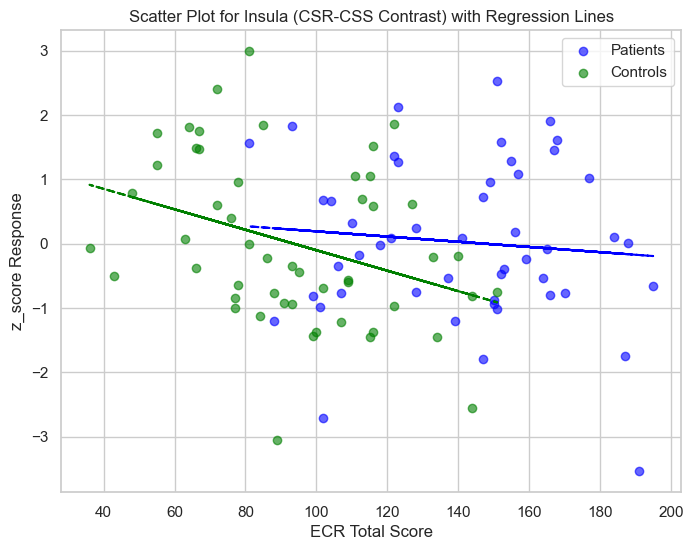

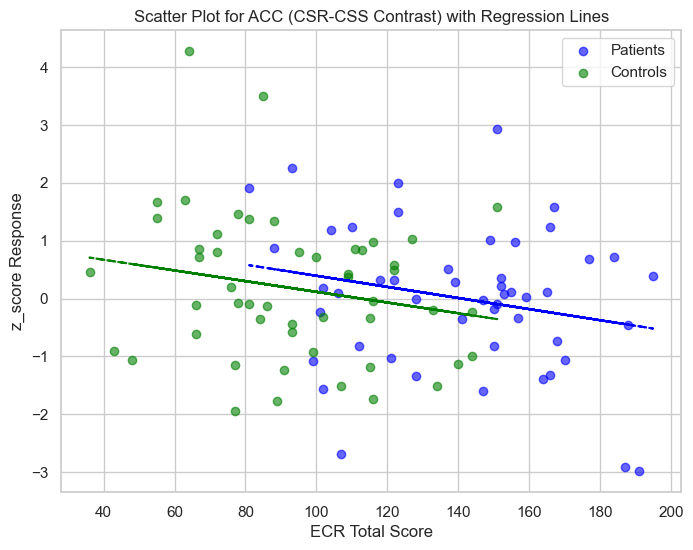

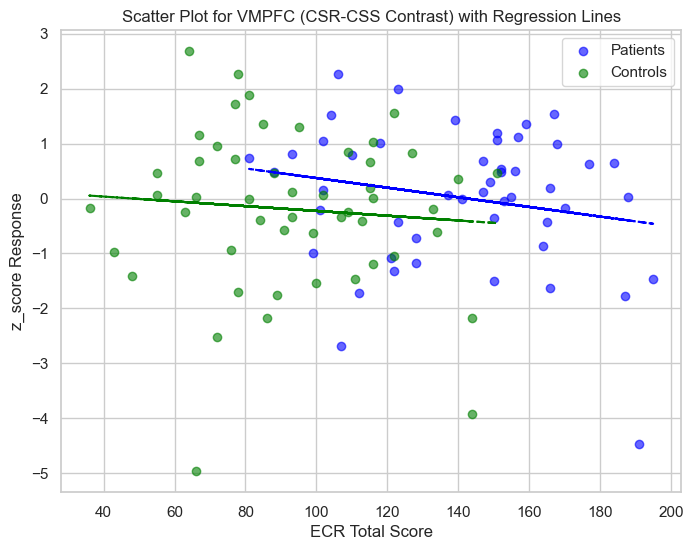

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Define regions of interest
regions_of_interest = [
    'Insula', 'ACC', 'VMPFC'
]

# Set your working directory
path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up ECR data
ecr_df = pd.read_excel('ECR.xlsx')
ecr_df.set_index('subID', inplace=True)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)

# Function to get patient group, gender, and ECR variables for each subject
def get_subject_data(sub_order):
    patient_groups, genders, ecr_total_score, ecr_anxiety, ecr_avoidance = [], [], [], [], []
    
    for sub in sub_order:
        subID = sub[3:7]
        
        patient_group = 1 if 'N1' in sub else 0
        patient_groups.append(patient_group)
        
        gender = drug_order_df.loc[subID].values[3]
        genders.append(gender)
        
        # Retrieve ECR variables
        ecr_row = ecr_df.loc[subID]
        ecr_total_score.append(ecr_row['total_score'])
        ecr_anxiety.append(ecr_row['Anxiety'])
        ecr_avoidance.append(ecr_row['Avoidance'])
    
    return (np.array(patient_groups), np.array(genders), 
            np.array(ecr_total_score), np.array(ecr_anxiety), np.array(ecr_avoidance))

# Function to create scatter plots with regression lines for each region, contrast, and group
def plot_scatter_with_regression(data, sub_order, contrast_name):
    patient_groups, _, ecr_total_score, _, _ = get_subject_data(sub_order)

    for region_no, region in enumerate(regions_of_interest):
        # Extract data for this region
        region_data = np.array([data[i].z_score()[region_no] for i in range(len(sub_order))])

        # Separate data by patient and control groups
        patients = patient_groups == 1
        controls = patient_groups == 0

        # Create the scatter plot
        plt.figure(figsize=(8, 6))
        plt.scatter(ecr_total_score[patients], region_data[patients], color='blue', label='Patients', alpha=0.6)
        plt.scatter(ecr_total_score[controls], region_data[controls], color='green', label='Controls', alpha=0.6)

        # Add regression lines
        if np.any(patients):
            patient_fit = np.poly1d(np.polyfit(ecr_total_score[patients], region_data[patients], 1))
            plt.plot(ecr_total_score[patients], patient_fit(ecr_total_score[patients]), color='blue', linestyle='--')
        if np.any(controls):
            control_fit = np.poly1d(np.polyfit(ecr_total_score[controls], region_data[controls], 1))
            plt.plot(ecr_total_score[controls], control_fit(ecr_total_score[controls]), color='green', linestyle='--')

        # Add labels and title
        plt.xlabel('ECR Total Score')
        plt.ylabel('z_score Response')
        plt.title(f'Scatter Plot for {region} ({contrast_name} Contrast) with Regression Lines')
        plt.legend()
        
        # Show the plot
        plt.show()

# Iterate over each contrast and create scatter plots with regression lines for all regions
for contrast, sub_order in sub_order_phase2.items():
    if contrast not in ['CSR-CSS']: #, 'CSS-fix', 'CSminus-fix']:
        continue  # Skip contrasts that are not part of CSR-fix, CSS-fix, CSminus-fix

    region_data = file_lists_phase2[contrast]
    print(f"\nScatter Plots for Contrast: {contrast}\n")
    plot_scatter_with_regression(region_data, sub_order, contrast)


##### Patients vs controls graphs for insula, vmpfc, acc


Statistics Table for Contrast: CSR-CSS

      Region  Patients Mean  Patients SD  Controls Mean  Controls SD  t-statistic  p-value
Right Insula       0.026474     1.247527       0.000797     1.278838     0.101635 0.919254
         ACC       0.001667     1.257997       0.175860     1.256465    -0.692614 0.490193
       VMPFC       0.015453     1.260739      -0.196872     1.445580     0.783639 0.435159


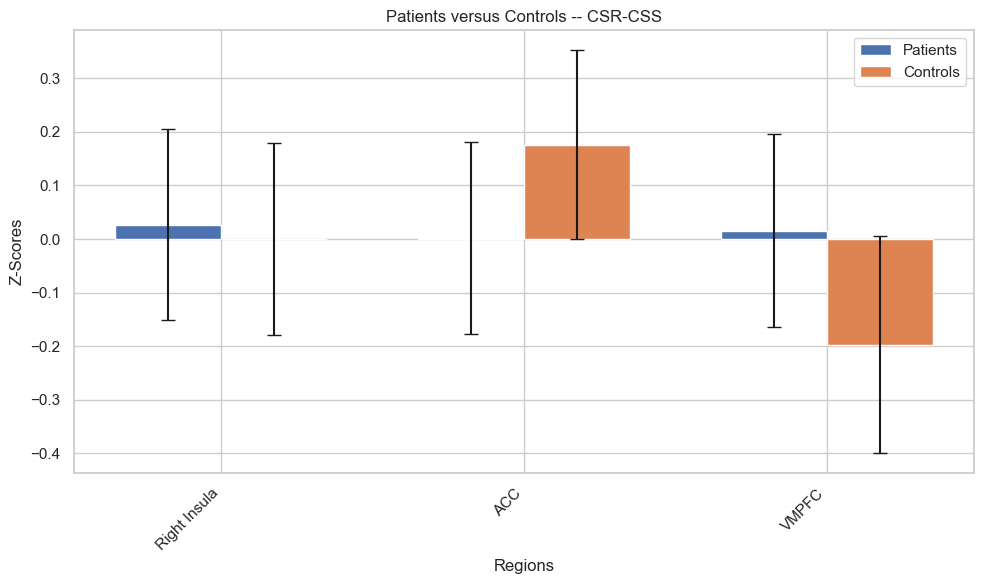


Statistics Table for Contrast: CSR-CS-

      Region  Patients Mean  Patients SD  Controls Mean  Controls SD  t-statistic  p-value
Right Insula       0.124219     1.480827       0.481821     1.361034    -1.255913 0.212179
         ACC       0.161178     1.541680       0.460679     1.332223    -1.037671 0.302064
       VMPFC      -0.179546     1.389521      -0.349507     1.527293     0.582478 0.561586


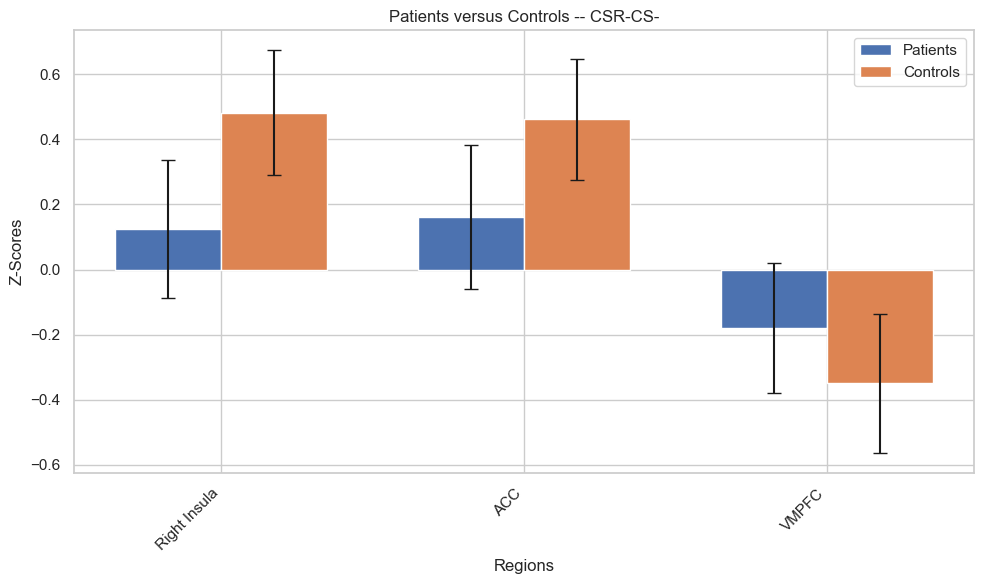


Statistics Table for Contrast: CSS-CS-

      Region  Patients Mean  Patients SD  Controls Mean  Controls SD  t-statistic  p-value
Right Insula       0.094581     1.350281       0.465862     1.482177    -1.310344 0.193151
         ACC       0.153968     1.320424       0.265228     1.374508    -0.412848 0.680620
       VMPFC      -0.184105     1.321860      -0.122098     1.311677    -0.235382 0.814405


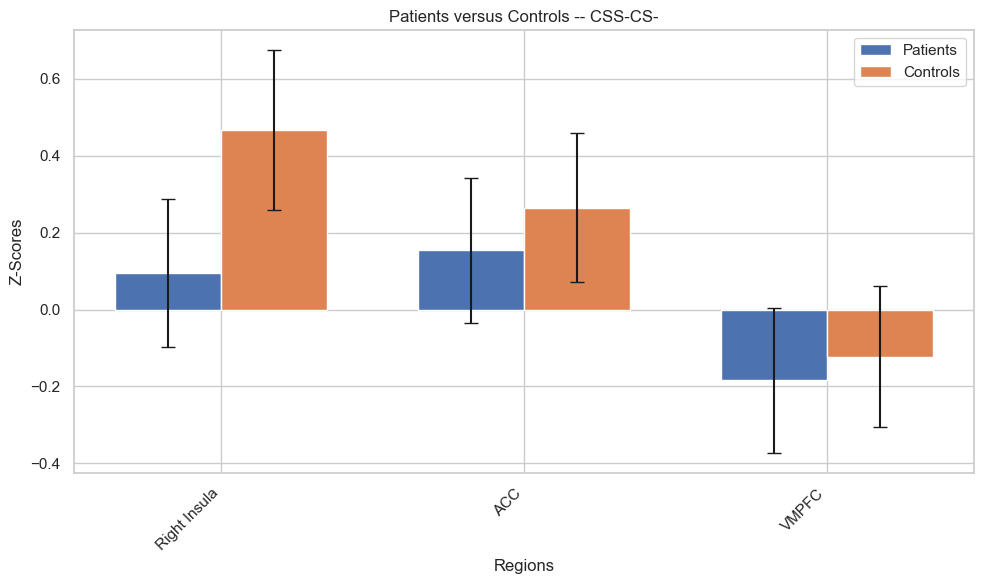


Statistics Table for Contrast: CSR-fix

      Region  Patients Mean  Patients SD  Controls Mean  Controls SD  t-statistic  p-value
Right Insula      -0.010613     1.106670       0.308745     1.277935    -1.337455 0.184203
         ACC      -0.321086     1.273793       0.038844     1.510504    -1.289988 0.200141
       VMPFC      -0.829665     1.304021      -0.903043     1.485530     0.262778 0.793277


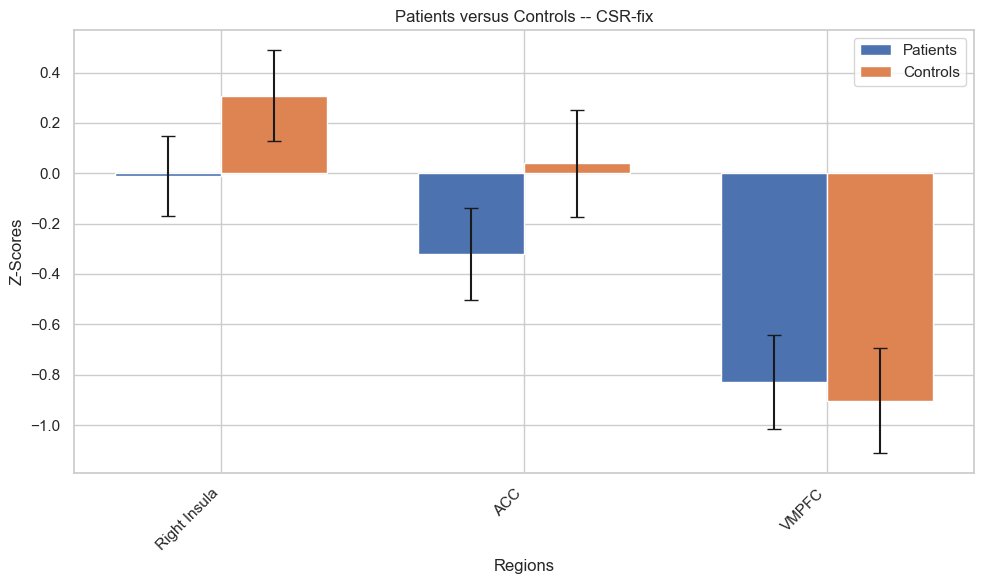


Statistics Table for Contrast: CSS-fix

      Region  Patients Mean  Patients SD  Controls Mean  Controls SD  t-statistic  p-value
Right Insula      -0.043799     1.114345       0.299066     1.380158    -1.369360 0.174108
         ACC      -0.310111     1.269924      -0.199938     1.300402    -0.428620 0.669141
       VMPFC      -0.810899     1.178019      -0.600282     1.380727    -0.821684 0.413279


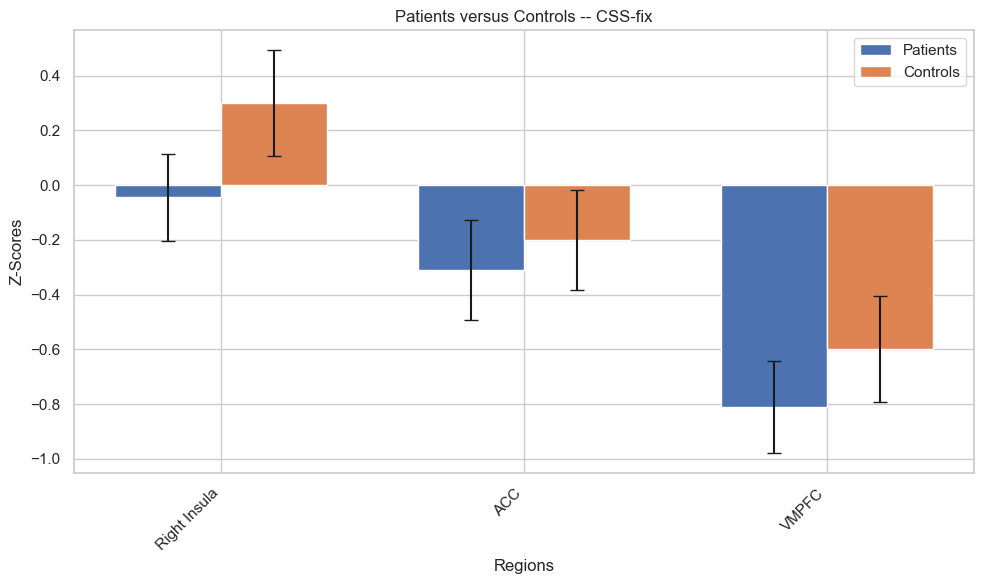


Statistics Table for Contrast: CSminus-fix

      Region  Patients Mean  Patients SD  Controls Mean  Controls SD  t-statistic  p-value
Right Insula      -0.187364     1.469251      -0.338054     1.430538     0.519370 0.604679
         ACC      -0.583084     1.489957      -0.614104     1.417880     0.106569 0.915351
       VMPFC      -0.674049     1.390747      -0.528505     1.241381    -0.551333 0.582690


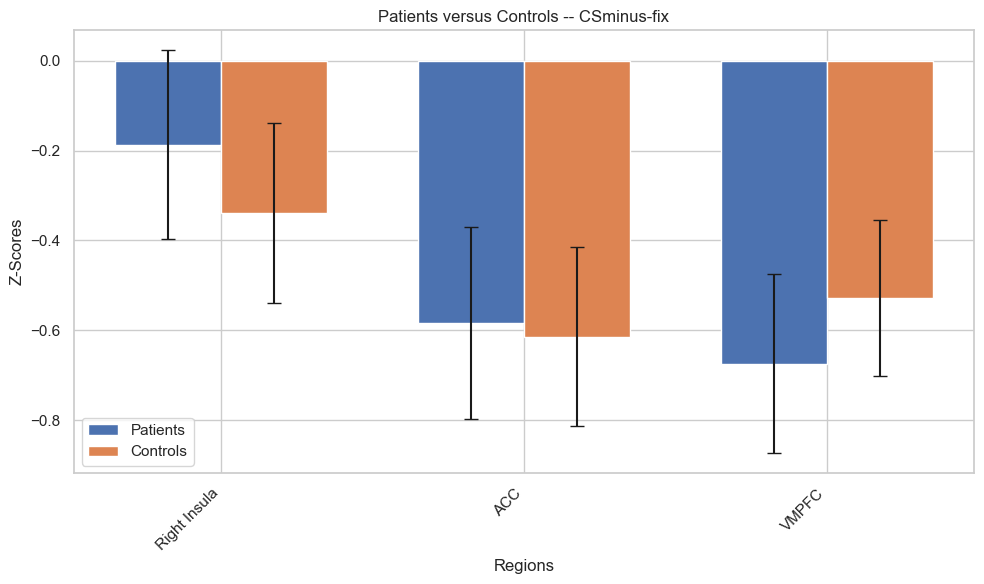

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# Assume that `file_lists_phase3` and `sub_order_phase3` are already defined

# Define your regions of interest
regions_of_interest = [
    'Right Insula', 'ACC', 'VMPFC'
]

# Separate subjects into patients (N100s) and controls (N200s)
def separate_groups(sub_order):
    patients = [i for i, sub in enumerate(sub_order) if 'N1' in sub]
    controls = [i for i, sub in enumerate(sub_order) if 'N2' in sub]
    return patients, controls

# Function to compute standard error of the mean
def compute_sem(data):
    return np.std(data, ddof=1) / np.sqrt(len(data))

# Function to add statistical significance (asterisk) annotations
def add_stat_annotation(ax, x_pos, y_max, width, p_value):
    if p_value < 0.05:
        # Add a line above the bars
        ax.plot([x_pos - width/2, x_pos + width/2], [y_max, y_max], color='black')
        # Add an asterisk above the line
        ax.text(x_pos, y_max, '*', ha='center', va='bottom', color='black', fontsize=14)

# Function to create multibar plots with z-scores, error bars, and significance annotations
def plot_multibar(data, sub_order, contrast):
    patients, controls = separate_groups(sub_order)
    
    # Store z-scores and SEM for all regions for patients and controls
    patient_zscores = []
    control_zscores = []
    patient_sem = []
    control_sem = []
    p_values = []
    t_stats = []

    # Data for the table
    stats_table = []

    for region_no in range(len(regions_of_interest)):
        # Extract z-score data for patients and controls
        patient_data = [data[i].z_score() for i in patients]
        control_data = [data[i].z_score() for i in controls]
        
        # Extract the z-scores for each region (1D data)
        patient_zscores_region = [pdd[region_no] for pdd in patient_data]
        control_zscores_region = [cdd[region_no] for cdd in control_data]
        
        # Compute the mean and SEM for patients and controls
        patient_mean = np.mean(patient_zscores_region)
        control_mean = np.mean(control_zscores_region)
        patient_std = np.std(patient_zscores_region, ddof=1)
        control_std = np.std(control_zscores_region, ddof=1)
        
        # Append mean and SEM values for plotting
        patient_zscores.append(patient_mean)
        control_zscores.append(control_mean)
        patient_sem.append(compute_sem(patient_zscores_region))
        control_sem.append(compute_sem(control_zscores_region))
        
        # Perform t-test between patients and controls for this region
        t_stat, p_value = ttest_ind(patient_zscores_region, control_zscores_region, equal_var=False)
        p_values.append(p_value)
        t_stats.append(t_stat)
        
        # Add to the stats table for this region
        stats_table.append([regions_of_interest[region_no], 
                            patient_mean, patient_std, 
                            control_mean, control_std, 
                            t_stat, p_value])

    # Convert the stats data into a pandas DataFrame for neat printing
    stats_df = pd.DataFrame(stats_table, columns=['Region', 
                                                  'Patients Mean', 'Patients SD', 
                                                  'Controls Mean', 'Controls SD', 
                                                  't-statistic', 'p-value'])
    print(f"\nStatistics Table for Contrast: {contrast}\n")
    print(stats_df.to_string(index=False))

    # Convert lists to arrays for easier plotting
    patient_means = np.array(patient_zscores)
    control_means = np.array(control_zscores)
    patient_errors = np.array(patient_sem)
    control_errors = np.array(control_sem)
    
    # Number of regions
    num_regions = len(regions_of_interest)
    
    # Bar plot setup
    x = np.arange(num_regions)  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot bars for patients and controls, including error bars (standard error)
    bars_patients = ax.bar(x - width/2, patient_means, width, yerr=patient_errors, label='Patients', capsize=5)
    bars_controls = ax.bar(x + width/2, control_means, width, yerr=control_errors, label='Controls', capsize=5)
    
    # Add labels, title, and custom x-axis tick labels
    ax.set_xlabel('Regions')
    ax.set_ylabel('Z-Scores')
    ax.set_title(f'Patients versus Controls -- {contrast}')
    ax.set_xticks(x)
    ax.set_xticklabels(regions_of_interest, rotation=45, ha='right')
    ax.legend()

    # Add significance asterisks for regions where p-value < 0.05
    y_max = np.max([patient_means + patient_errors, control_means + control_errors]) * 1.05  # adjust y_max for placement
    for region_no, p_value in enumerate(p_values):
        if p_value < 0.05:
            add_stat_annotation(ax, x_pos=x[region_no], y_max=y_max, width=width, p_value=p_value)

    plt.tight_layout()
    plt.show()

# Iterate over each contrast and create a multibar plot and stats table for all regions
for contrast, sub_order in sub_order_phase2.items():
    region_data = file_lists_phase2[contrast]  # Extract data for this contrast
    plot_multibar(region_data, sub_order, contrast)


### Reinstatement Analysis

#### Reinstatement SCR 

In [83]:
# intercept included cs- data, control data, placebo data see specific effect of drug, css, csr, etc. 
path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('ECR.xlsx')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['ECR_total'] = merged_data['total_score']  # Gender as categorical
merged_data['ECR_anxiety'] = merged_data['Anxiety']  # Drug as categorical
merged_data['ECR_avoidance'] = merged_data['Avoidance']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'ECR_total','ECR_avoidance','ECR_anxiety'], 
                    value_vars=['meanCSR3', 'meanCSS3', 'meanCSminus3'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR3': 1, 
    'meanCSS3': 2, 
    'meanCSminus3': 3
})


# Model formula including main effect of stim_type
model_formula = 'response ~ patient_group + stim_type + ECR_total'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.2248
Date:                Fri, 01 Nov 2024   Prob (F-statistic):              0.879
Time:                        14:35:43   Log-Likelihood:                 370.19
No. Observations:                 303   AIC:                            -732.4
Df Residuals:                     299   BIC:                            -717.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0612      0.018      3.419

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60537/3394761560.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


#### Reinstatement ROI analysis (fmri)


In [78]:
### dep variable includes CSR-fix, CSS-fix, CSminus-fix and independent vars include effect of stimulus type

import pandas as pd
import statsmodels.api as sm
import numpy as np
import os

# Set your working directory
path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up ECR data
ecr_df = pd.read_excel('ECR.xlsx')
ecr_df.set_index('subID', inplace=True)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)

# Define regions of interest
regions_of_interest = [
    'Insula', 'ACC', 'VMPFC'
]

# Function to get patient group and gender for each subject and ECR variables
def get_subject_data(sub_order):
    patient_groups, genders, ecr_total_score, ecr_anxiety, ecr_avoidance = [], [], [], [], []
    
    for sub in sub_order:
        subID = sub[3:7]
        
        patient_group = 1 if 'N1' in sub else 0
        patient_groups.append(patient_group)
        
        gender = drug_order_df.loc[subID].values[3]
        genders.append(gender)
        
        # Retrieve ECR variables
        ecr_row = ecr_df.loc[subID]
        ecr_total_score.append(ecr_row['total_score'])
        ecr_anxiety.append(ecr_row['Anxiety'])
        ecr_avoidance.append(ecr_row['Avoidance'])
    
    return (np.array(patient_groups), np.array(genders), 
            np.array(ecr_total_score), np.array(ecr_anxiety), np.array(ecr_avoidance))

# Function to prepare data and run regression for each region including stimulus type
def run_regression(data_dict, sub_order_dict):
    regression_results = []

    # Map stimulus types to integers for CSR-fix, CSS-fix, and CSminus-fix only
    stimulus_map = {
        'CSR-fix': 0,
        'CSS-fix': 1,
        'CSminus-fix': 2
    }

    # Loop over each region
    for region_no, region in enumerate(regions_of_interest):
        # Collect all data for this region across selected contrasts
        region_data_list = []
        predictors_list = []

        for contrast, sub_order in sub_order_dict.items():
            # Skip contrasts that are not CSR-fix, CSS-fix, or CSminus-fix
            if contrast not in stimulus_map:
                continue
            
            region_data = np.array([data_dict[contrast][i].z_score()[region_no] for i in range(len(sub_order))])
            
            # Get subject-level variables
            patient_groups, genders, ecr_total_score, ecr_anxiety, ecr_avoidance = get_subject_data(sub_order)
            
            # Assign a numerical code to stimulus type
            stimulus_type = stimulus_map[contrast]
            # Calculate interaction term
            interaction_term = patient_groups * ecr_avoidance
            
            # Prepare the independent variables with column names
            predictors = pd.DataFrame({
                'Patient Group': patient_groups,
                'ECR avoidance': ecr_avoidance,
                'Patient Group * ECR avoidance': interaction_term,
                'Stimulus Type': stimulus_type
            })            
            
            # Append region data and predictors to lists
            region_data_list.append(region_data)
            predictors_list.append(predictors)
        
        # Concatenate region data and predictors for all selected contrasts
        Y = np.concatenate(region_data_list)
        X = pd.concat(predictors_list)
        
        # Add a constant to the model for the intercept
        X = sm.add_constant(X)
        
        # Fit the model
        model = sm.OLS(Y, X).fit()
        
        # Print the summary for each region
        print(f"\nRegression Summary for {region}:")
        print(model.summary())

# Run regression for all regions with selected contrasts only
run_regression(file_lists_phase3, sub_order_phase3)



Regression Summary for Insula:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.5816
Date:                Fri, 01 Nov 2024   Prob (F-statistic):              0.676
Time:                        14:31:12   Log-Likelihood:                -526.35
No. Observations:                 303   AIC:                             1063.
Df Residuals:                     298   BIC:                             1081.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [80]:
### RUNNING EACH CONTRAST SEP 
import pandas as pd
import statsmodels.api as sm
import numpy as np
import os

# Define regions of interest
regions_of_interest = [
    'Insula', 'ACC', 'VMPFC'
]

# Set your working directory
path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up ECR data
ecr_df = pd.read_excel('ECR.xlsx')
ecr_df.set_index('subID', inplace=True)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)

# Function to get patient group, gender, and ECR variables for each subject
def get_subject_data(sub_order):
    patient_groups, genders, ecr_total_score, ecr_anxiety, ecr_avoidance = [], [], [], [], []
    
    for sub in sub_order:
        subID = sub[3:7]
        
        patient_group = 1 if 'N1' in sub else 0
        patient_groups.append(patient_group)
        
        gender = drug_order_df.loc[subID].values[3]
        genders.append(gender)
        
        # Retrieve ECR variables
        ecr_row = ecr_df.loc[subID]
        ecr_total_score.append(ecr_row['total_score'])
        ecr_anxiety.append(ecr_row['Anxiety'])
        ecr_avoidance.append(ecr_row['Avoidance'])
    
    return (np.array(patient_groups), np.array(genders), 
            np.array(ecr_total_score), np.array(ecr_anxiety), np.array(ecr_avoidance))

# Function to run linear regression for each region with interaction term
def run_regression(data, sub_order):
    patient_groups, genders, ecr_total_score, ecr_anxiety, ecr_avoidance = get_subject_data(sub_order)

    for region_no, region in enumerate(regions_of_interest):
        # Extract data for this region
        region_data = np.array([data[i].z_score()[region_no] for i in range(len(sub_order))])
        
        # Calculate interaction term
        interaction_term = patient_groups * ecr_total_score
        
        # Prepare the independent variables with column names
        X = pd.DataFrame({
            'Patient Group': patient_groups,
            'ECR total_score': ecr_total_score,
            'Patient Group * ECR total_score': interaction_term
        })
        X = sm.add_constant(X)  # Add a constant for the intercept
        
        Y = region_data
        model = sm.OLS(Y, X).fit()
        
        # Print the summary of the regression model for this region
        print(f"\nRegression Summary for {region}:")
        print(model.summary())

# Iterate over each contrast and run regression for all regions
for contrast, sub_order in sub_order_phase3.items():
    region_data = file_lists_phase3[contrast]
    print(f"\nLinear Regression Results for Contrast: {contrast}\n")
    run_regression(region_data, sub_order)




Linear Regression Results for Contrast: CSR-CSS


Regression Summary for Insula:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.6754
Date:                Fri, 01 Nov 2024   Prob (F-statistic):              0.569
Time:                        14:32:56   Log-Likelihood:                -177.25
No. Observations:                 101   AIC:                             362.5
Df Residuals:                      97   BIC:                             373.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------


Scatter Plots for Contrast: CSR-CSS



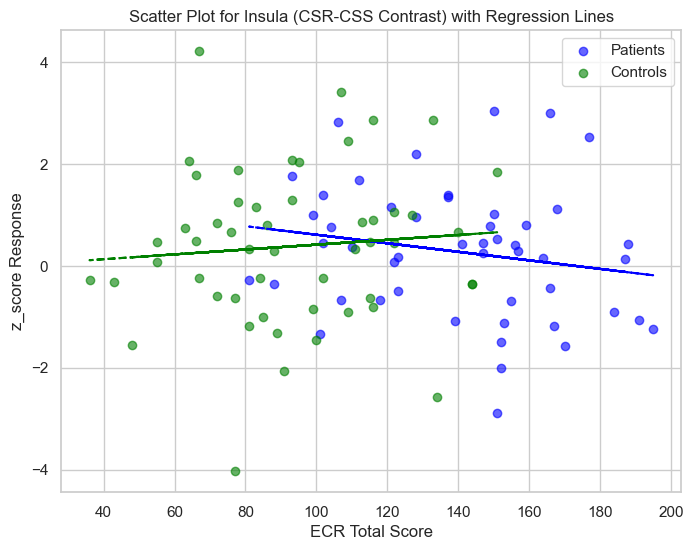

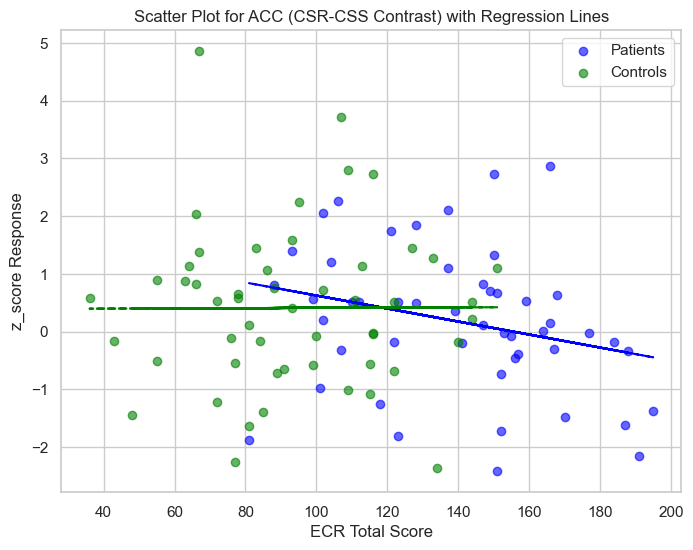

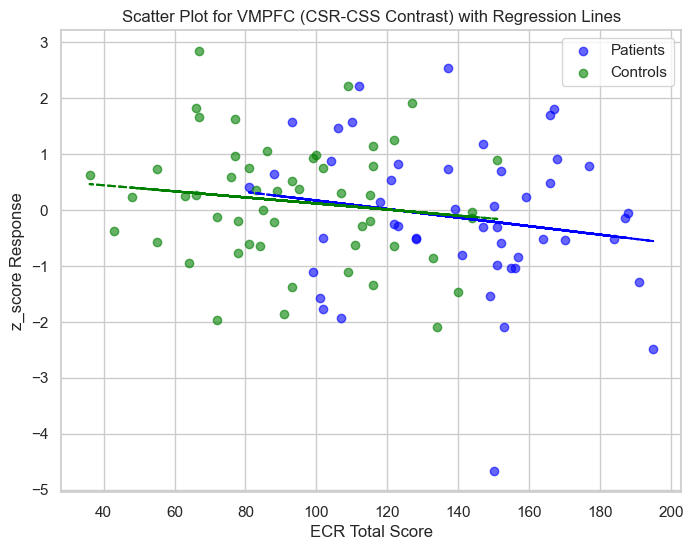

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Define regions of interest
regions_of_interest = [
    'Insula', 'ACC', 'VMPFC'
]

# Set your working directory
path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up ECR data
ecr_df = pd.read_excel('ECR.xlsx')
ecr_df.set_index('subID', inplace=True)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)

# Function to get patient group, gender, and ECR variables for each subject
def get_subject_data(sub_order):
    patient_groups, genders, ecr_total_score, ecr_anxiety, ecr_avoidance = [], [], [], [], []
    
    for sub in sub_order:
        subID = sub[3:7]
        
        patient_group = 1 if 'N1' in sub else 0
        patient_groups.append(patient_group)
        
        gender = drug_order_df.loc[subID].values[3]
        genders.append(gender)
        
        # Retrieve ECR variables
        ecr_row = ecr_df.loc[subID]
        ecr_total_score.append(ecr_row['total_score'])
        ecr_anxiety.append(ecr_row['Anxiety'])
        ecr_avoidance.append(ecr_row['Avoidance'])
    
    return (np.array(patient_groups), np.array(genders), 
            np.array(ecr_total_score), np.array(ecr_anxiety), np.array(ecr_avoidance))

# Function to create scatter plots with regression lines for each region, contrast, and group
def plot_scatter_with_regression(data, sub_order, contrast_name):
    patient_groups, _, ecr_total_score, _, _ = get_subject_data(sub_order)

    for region_no, region in enumerate(regions_of_interest):
        # Extract data for this region
        region_data = np.array([data[i].z_score()[region_no] for i in range(len(sub_order))])

        # Separate data by patient and control groups
        patients = patient_groups == 1
        controls = patient_groups == 0

        # Create the scatter plot
        plt.figure(figsize=(8, 6))
        plt.scatter(ecr_total_score[patients], region_data[patients], color='blue', label='Patients', alpha=0.6)
        plt.scatter(ecr_total_score[controls], region_data[controls], color='green', label='Controls', alpha=0.6)

        # Add regression lines
        if np.any(patients):
            patient_fit = np.poly1d(np.polyfit(ecr_total_score[patients], region_data[patients], 1))
            plt.plot(ecr_total_score[patients], patient_fit(ecr_total_score[patients]), color='blue', linestyle='--')
        if np.any(controls):
            control_fit = np.poly1d(np.polyfit(ecr_total_score[controls], region_data[controls], 1))
            plt.plot(ecr_total_score[controls], control_fit(ecr_total_score[controls]), color='green', linestyle='--')

        # Add labels and title
        plt.xlabel('ECR Total Score')
        plt.ylabel('z_score Response')
        plt.title(f'Scatter Plot for {region} ({contrast_name} Contrast) with Regression Lines')
        plt.legend()
        
        # Show the plot
        plt.show()

# Iterate over each contrast and create scatter plots with regression lines for all regions
for contrast, sub_order in sub_order_phase3.items():
    if contrast not in ['CSR-CSS']: #, 'CSS-fix', 'CSminus-fix']:
        continue  # Skip contrasts that are not part of CSR-fix, CSS-fix, CSminus-fix

    region_data = file_lists_phase3[contrast]
    print(f"\nScatter Plots for Contrast: {contrast}\n")
    plot_scatter_with_regression(region_data, sub_order, contrast)
